
## Alexnet Initial declarations it includes
- **Imports Libraries**: Utilizes PyTorch, torchvision, and tensorboard for deep learning and logging.
- **Device Setup**: Defines `cuda` or `cpu` as the execution device based on availability.
- **Model Parameters**: Specifies epochs, batch size, image dimensions, and directories for output and logs.
- **Checkpoint Directory**: Creates a directory to save model checkpoints.
- **Defines AlexNet**: Implements a modified AlexNet architecture with two branches and initializes layers.
- **Transforms and Datasets**: Applies data augmentation and loads CIFAR-10 training and test datasets.
- **Dataloader**: Prepares data loaders for training with specified batch size and workers.
- **Optimizer and Scheduler**: Sets up Adam optimizer and learning rate scheduler to adjust learning rate on plateaus.
- **Training Loop**: Trains the model over several epochs, computes loss, updates weights, logs metrics, and validates accuracy periodically.
- **Early Stopping**: Stops training if model accuracy exceeds a defined threshold during validation.

In [1]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# Define pytorch device - useful for device-agnostic execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define model parameters
NUM_EPOCHS = 100
BATCH_SIZE = 512
IMAGE_DIM = 32  # pixels
NUM_CLASSES = 10  # 10 classes for CIFAR-10 dataset
DEVICE_IDS = [0]  # GPUs to use
OUTPUT_DIR = 'alexnet_data_out'
LOG_DIR = OUTPUT_DIR + '/tblogs'  # tensorboard logs
CHECKPOINT_DIR = OUTPUT_DIR + '/models'  # model checkpoints

# Make checkpoint path directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hack to debug in the middle of a sequential 
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.size())
        return x

class AlexNet(nn.Module):
    """
    Neural network model consisting of layers proposed by AlexNet paper.
    """
    
    def __init__(self, num_classes=NUM_CLASSES):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()

        # Main net
        self.norm = nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(64, 192, 5, padding=1)
        self.conv3 = nn.Conv2d(192, 384, 3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu = nn.ReLU()

        self.mainConvLayers = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]

        # Branch 1
        self.branch1 = nn.Sequential(
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75, k=2.0),
            nn.Conv2d(64, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.branch1fc = nn.Linear(1568, 10)

        # Branch 2
        self.branch2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75, k=2),
            nn.Conv2d(192, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.branch2fc = nn.Linear(128, 10)

        # Linear layers of main branch
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),  # inplace=False
            nn.Linear(in_features=(256 * 2 * 2), out_features=4096),
            nn.ReLU(inplace=False),  # inplace=False
            nn.Dropout(p=0.5, inplace=False),  # inplace=False
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),  # inplace=False
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init_bias()  # initialize bias

    def init_bias(self):
        for layer in self.branch1:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

        for layer in self.branch2:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

        for layer in self.mainConvLayers:
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            nn.init.constant_(layer.bias, 0)

        # Original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv2.bias, 1)
        nn.init.constant_(self.conv4.bias, 1)
        nn.init.constant_(self.conv5.bias, 1)
        
    def forward(self, x):
        """
        Pass the input through the net.
        Args:
            x (Tensor): input tensor
        Returns:
            output (Tensor): output tensor
        """
        x = self.conv1(x)

        #BRANCH 1: 2 3x3 conv and one FC layer
        x1 = self.branch1(x)
        x1 = x1.view(-1, 1568)
        x1 = self.branch1fc(x1)

        x = self.relu(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.conv2(x)

        #BRANCH 2: 1 3x3 conv and one FC layer
        x2 = self.branch2(x)
        x2 = x2.view(-1, 128)
        x2 = self.branch2fc(x2)

        x = self.relu(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.relu(self.conv5(x))
        x = self.pool(x)
        x = x.view(x.size(0), 256 * 2 * 2)  # reduce the dimensions for linear layer input
        x = self.classifier(x)
        return x1, x2, x


if __name__ == '__main__':
    # Print the seed value
    seed = torch.initial_seed()
    print('Used seed : {}'.format(seed))
    torch.autograd.set_detect_anomaly(True)

    tbwriter = SummaryWriter(log_dir=LOG_DIR)
    print('TensorboardX summary writer created')

    # Create model
    alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
    # Train on multiple GPUs
    alexnet = torch.nn.parallel.DataParallel(alexnet, device_ids=DEVICE_IDS)
    print(alexnet)
    print('AlexNet created')

    # transforms are functions that modify the image while feeding into the nn 
    # this transformation pipeline applies several data augmentation and preprocessing steps to the input images:
    # 1. Randomly flips the image horizontally.
    # 2. (Commented out) Optionally applies a random rotation of up to 15 degrees.
    # 3. Randomly crops a region of the image, resizing it to the desired dimensions while keeping the aspect ratio close to original.
    # 4. Centers the cropped region to a fixed size.
    # 5. Converts the image to a PyTorch tensor.
    # 6. Normalizes the tensor using the mean and standard deviation specific to the CIFAR-10 dataset.
    
    
    transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(15),
        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    
    dataset = datasets.CIFAR10(root='./data', train=True, transform=transform,
                               download=True)
    
    testtransform = transforms.Compose([
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
    testdata = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
    print('Dataset created')
    
    dataloader = data.DataLoader(
        dataset,
        shuffle=True,
        pin_memory=True,
        num_workers=8,
        drop_last=True,
        batch_size=BATCH_SIZE)
    print('Dataloader created')

    optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)
    print('Optimizer created')

    # Multiply LR if plateaus
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    print('LR Scheduler created')

    # Start training!!
    print('Starting training...')
    alexnet.train()
    total_steps = 1
    end = False
    for epoch in range(NUM_EPOCHS):
        loss1 = 0
        for imgs, classes in dataloader:
            imgs, classes = imgs.to(device), classes.to(device)
            optimizer.zero_grad()
            # Calculate the loss
            output = alexnet(imgs)[-1]
            optimizer.zero_grad()
            loss = F.cross_entropy(output, classes)
            loss1 = loss

            # Update the parameters
            loss.backward()
            optimizer.step()

            # Log the information and add to tensorboard
            if total_steps % 10 == 0:
                # with torch.no_grad():
                _, preds = torch.max(output, 1)
                accuracy = torch.sum(preds == classes)

                print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                    .format(epoch + 1, total_steps, loss.item(), accuracy.item()))

            if total_steps % 30 == 0:
                #~~~~~~~VALIDATION~~~~~~~~~
                valdataloader = data.DataLoader(
                    testdata,
                    shuffle=True,
                    pin_memory=True,
                    num_workers=8,
                    drop_last=True,
                    batch_size=512)
                correct_count = 0
                total_count = 0
                alexnet.eval()
                for images, labels in valdataloader:
                    images, labels = images.to(device), labels.to(device)
                    with torch.no_grad():  # No gradient descent!
                        logps = alexnet(images)[-1]
                    
                    for i in range(BATCH_SIZE):
                        ps = torch.exp(logps)
                        prob = list(ps.cpu().numpy()[i])
                        pred_label = prob.index(max(prob))
                        true_label = labels.cpu().numpy()[i]
                        if true_label == pred_label:
                            correct_count += 1
                        total_count += 1
                print("Number Of Images Tested =", total_count)
                print("\nModel Accuracy =", (correct_count / total_count))
                if correct_count / total_count > 0.83:
                    end = True
                alexnet.train()
            if end:
                break

            total_steps += 1
        if end:
            break
        lr_scheduler.step(loss1)
        '''
        Used seed : 692119145479470688
        '''


cuda
Used seed : 7484048785814097422
TensorboardX summary writer created
DataParallel(
  (module): AlexNet(
    (norm): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=1.0)
    (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv1): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (conv3): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu): ReLU()
    (branch1): Sequential(
      (0): ReLU()
      (1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): LocalResponseNorm(3, alpha=5e-05, beta=0.75, k=2.0)
      (3): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU()
      (5): Conv2d(32, 32, kernel

Exception ignored in: <function _releaseLock at 0x7fea2e0f2160>
Traceback (most recent call last):
  File "/usr/lib/python3.8/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 
Exception in thread Thread-5:
Traceback (most recent call last):
  File "/usr/lib/python3.8/threading.py", line 932, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.8/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 54, in _pin_memory_loop
    do_one_step()
  File "/usr/local/lib/python3.8/dist-packages/torch/utils/data/_utils/pin_memory.py", line 31, in do_one_step
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.8/multiprocessing/queues.py", line 116, in get
    return _ForkingPickler.loads(res)
  File "/usr/local/lib/python3.8/dist-packages/torch/multiprocessing/reductions.py", line 355, in rebuild_storage_f

RuntimeError: DataLoader worker (pid(s) 101563, 101564, 101565, 101566) exited unexpectedly

response = connection.recv_bytes(256)        # reject large message
  File "/usr/lib/python3.8/multiprocessing/connection.py", line 216, in recv_bytes
    fd = df.detach()
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/usr/lib/python3.8/multiprocessing/resource_sharer.py", line 87, in get_connection


# Testing the main branch


In [48]:
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform,download=True)

# Data loader creates an iterable from data set according to the batch size

dataloader = data.DataLoader(
    testingData,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
correct_count = 0
total_count = 0

# alexnet.eval() sets the model in evaluation mode by loading the weghts and logic in the gpu (**this is always required before testing the model)
alexnet.eval()


for imgs, classes in dataloader:
    imgs, classes = imgs.to(device), classes.to(device)

    with torch.no_grad(): #no gradient descent!
        logps = alexnet(imgs)[-1]
    for i in range(BATCH_SIZE):
        ps = torch.exp(logps)
        prob = list(ps.cpu().numpy()[i])
        pred_labels = prob.index(max(prob))
        true_labels = classes.cpu().numpy()[i]
        if(true_labels == pred_labels):
            correct_count += 1
        total_count += 1
    # updating the evaluation results to the user for every 10 x batch size images tested
    if total_count % 10 == 0:
        print(f"total: {total_count}, correct: {correct_count}")
print("Number Of Images Tested =", total_count)
print("\nModel Accuracy =", (correct_count/total_count))


Files already downloaded and verified
total: 2560, correct: 2031
total: 5120, correct: 4064
total: 7680, correct: 6149
Number Of Images Tested = 9728

Model Accuracy = 0.796875


# Inspecting the weights by printing them with hooks

In [49]:
# torch no grad is used to freeze the weights without updating them while inspecting with hook functions or testing the model
# esentially stops gradient descent and maintains weight integrity
with torch.no_grad():
    # print and save the grad of the parameters
    # also print and save parameter values
    print('*' * 10)
    for name, parameter in alexnet.named_parameters():
        if parameter.grad is not None:
            avg_grad = torch.mean(parameter.grad)
            print('\t{} - grad_avg: {}'.format(name, avg_grad))
            tbwriter.add_scalar('grad_avg/{}'.format(name), avg_grad.item(), total_steps)
            tbwriter.add_histogram('grad/{}'.format(name),
                    parameter.grad.cpu().numpy(), total_steps)
        if parameter.data is not None:
            avg_weight = torch.mean(parameter.data)
            print('\t{} - param_avg: {}'.format(name, avg_weight))
            tbwriter.add_histogram('weight/{}'.format(name),
                    parameter.data.cpu().numpy(), total_steps)
            tbwriter.add_scalar('weight_avg/{}'.format(name), avg_weight.item(), total_steps)

**********
	module.conv1.weight - grad_avg: -0.021572686731815338
	module.conv1.weight - param_avg: -0.00022805744083598256
	module.conv1.bias - grad_avg: 0.049633197486400604
	module.conv1.bias - param_avg: 0.015439438633620739
	module.conv2.weight - grad_avg: -0.00031650534947402775
	module.conv2.weight - param_avg: -0.00362833752296865
	module.conv2.bias - grad_avg: -0.002022606087848544
	module.conv2.bias - param_avg: 0.9942011833190918
	module.conv3.weight - grad_avg: -0.0004743762547150254
	module.conv3.weight - param_avg: -0.0013622953556478024
	module.conv3.bias - grad_avg: -0.0008669761009514332
	module.conv3.bias - param_avg: -0.00024229983682744205
	module.conv4.weight - grad_avg: 5.9409016103018075e-05
	module.conv4.weight - param_avg: -0.0017319639446213841
	module.conv4.bias - grad_avg: 0.0006965358043089509
	module.conv4.bias - param_avg: 0.9915634393692017
	module.conv5.weight - grad_avg: -4.535403786576353e-05
	module.conv5.weight - param_avg: -0.0035100604873150587
	m

# Testing to confirm branches did NOT learn

In [50]:
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform,
                               download=True)
dataloader = data.DataLoader(
    testingData,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
correct_count = 0
total_count = 0
alexnet.eval()
for imgs, classes in dataloader:
    imgs, classes = imgs.to(device), classes.to(device)

    with torch.no_grad(): #no gradient descent!
        logps = alexnet(imgs)[0]
    for i in range(BATCH_SIZE):
        ps = torch.exp(logps)
        prob = list(ps.cpu().numpy()[i])
        pred_labels = prob.index(max(prob))
        true_labels = classes.cpu().numpy()[i]
        if(true_labels == pred_labels):
            correct_count += 1
        total_count += 1

print("\nBranch1 Accuracy =", (correct_count/total_count))

testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform,
                               download=True)
dataloader = data.DataLoader(
    testingData,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
correct_count = 0
total_count = 0
alexnet.eval()
for imgs, classes in dataloader:
    imgs, classes = imgs.to(device), classes.to(device)

    with torch.no_grad(): #no gradient descent!
        logps = alexnet(imgs)[1]
    for i in range(BATCH_SIZE):
        ps = torch.exp(logps)
        prob = list(ps.cpu().numpy()[i])
        pred_labels = prob.index(max(prob))
        true_labels = classes.cpu().numpy()[i]
        if(true_labels == pred_labels):
            correct_count += 1
        total_count += 1

print("\nBranch2 Accuracy =", (correct_count/total_count))

testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform,
                               download=True)
dataloader = data.DataLoader(
    testingData,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
correct_count = 0
total_count = 0
alexnet.eval()
for imgs, classes in dataloader:
    imgs, classes = imgs.to(device), classes.to(device)

    with torch.no_grad(): #no gradient descent!
        logps = alexnet(imgs)[2]
    for i in range(BATCH_SIZE):
        ps = torch.exp(logps)
        prob = list(ps.cpu().numpy()[i])
        pred_labels = prob.index(max(prob))
        true_labels = classes.cpu().numpy()[i]
        if(true_labels == pred_labels):
            correct_count += 1
        total_count += 1

print("\nMain Accuracy =", (correct_count/total_count))

Files already downloaded and verified

Branch1 Accuracy = 0.08727384868421052
Files already downloaded and verified

Branch2 Accuracy = 0.08418996710526316
Files already downloaded and verified

Main Accuracy = 0.7962582236842105


# Train the model with branches this includes the joint sum solution of updating model weights as per the paper

In [1]:
NUM_EPOCHS = 750
BATCH_SIZE = 512
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(15),
        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

dataset = datasets.CIFAR10(root='./data', train=True, transform=transform,
                            download=True)

testtransform = transforms.Compose([
    transforms.CenterCrop(IMAGE_DIM),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])
testdata = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
print('Dataset created')

dataloader = data.DataLoader(
    dataset,
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)
print('Dataloader created')

optimizer = optim.Adam(params=alexnet.parameters(), lr=0.0001)
print('Optimizer created')

lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=15, verbose=True)

print('LR Scheduler created')

# start training!!
print('Starting training...')
alexnet.train()
total_steps = 1
end = False
val_loss = 20
for epoch in range(NUM_EPOCHS):
    loss1 = 0
    for imgs, classes in dataloader:
        imgs, classes = imgs.to(device), classes.to(device)
        optimizer.zero_grad()
        # calculate the loss
        outputb1, outputb2, outputmain = alexnet(imgs)
        lossb1 = F.cross_entropy(outputb1, classes)
        lossb2 = F.cross_entropy(outputb2, classes)
        lossmain = F.cross_entropy(outputmain, classes)
        # the joint sum of different losses
        loss = 0.5*lossb1 + 0.3*lossb2 + 0.2*lossmain
        loss1 = loss
        
        # saving the model as a state-dict with minimal net loss as minimal loss tends to higher accuracy
        if loss <  val_loss:
            val_loss = loss
            checkpoint_path = os.path.join("./models", 'Branchy-alexnet_states-bst3-2.pkl')
            import copy
            # Create a deep copy of the state to ensure weight integrity and presicison while saving
            state = {
                'epoch': epoch,
                'total_steps': total_steps,
                'optimizer': copy.deepcopy(optimizer.state_dict()),
                'model': copy.deepcopy(alexnet.state_dict()),
                'seed': seed,
            }

            # Save the state dictionary as a .pkl file
            torch.save(state, checkpoint_path)
            
        
        # update the parameters
        loss.backward()
        optimizer.step()

        # log the information and add to tensorboard
        if total_steps % 10 == 0:
            #with torch.no_grad():
            _, preds = torch.max(outputmain, 1)
            accuracy = torch.sum(preds == classes)

            print('Epoch: {} \tStep: {} \tLoss: {:.4f} \tAcc: {}'
                .format(epoch + 1, total_steps, loss.item(), accuracy.item()))
            print(f'Branch 1: loss {lossb1}')
            print(f'Branch 2: loss {lossb2}')
            print(f'Main: loss {lossmain}')

        if total_steps % 300 == 0:

            #~~~~~~~VALIDATION~~~~~~~~~
            valdataloader = data.DataLoader(
                testdata,
                shuffle=True,
                pin_memory=True,
                num_workers=8,
                drop_last=True,
                batch_size=BATCH_SIZE )
            b1_correct = 0
            b2_correct = 0
            main_correct = 0
            total_count = 0
            alexnet.eval()
            for image, label in valdataloader:
                image, label = image.to(device), label.to(device)
                with torch.no_grad(): #no gradient descent!
                    b1, b2, main = alexnet(image)
                
                b1ps = torch.exp(b1)
                b2ps = torch.exp(b2)
                mainps = torch.exp(main)
                for i in range(BATCH_SIZE):
                    b1prob = list(b1ps.cpu().numpy()[i])
                    b2prob = list(b2ps.cpu().numpy()[i])
                    mainprob = list(main.cpu().numpy()[i])


                    b1label = b1prob.index(max(b1prob))
                    b2label = b2prob.index(max(b2prob))
                    mainlabel = mainprob.index(max(mainprob))

                    true_label = label.cpu().numpy()[i]

                    if(true_label == b1label):
                        b1_correct += 1

                    if(true_label == b2label):
                        b2_correct += 1

                    if(true_label == mainlabel):
                        main_correct += 1

                    total_count += 1

            print("Number Of Images Tested =", total_count*128)
            print(f"b1 acc: {b1_correct/total_count}, b2 acc: {b2_correct/total_count}, main acc: {main_correct/total_count}")
            alexnet.train()
        if end:
            break

        total_steps += 1
    if end:
        break
    lr_scheduler.step(loss1)

NameError: name 'transforms' is not defined

# save checkpoint/weights as state-dicts of the model at the end of the training cycle to compare weather loss effects accuracy


In [40]:

        checkpoint_path = os.path.join("./models", 'Branchy-alexnet_states-bst3-1.pkl')
        import copy
        # Create a deep copy of the state
        state = {
            'epoch': epoch,
            'total_steps': total_steps,
            'optimizer': copy.deepcopy(optimizer.state_dict()),
            'model': copy.deepcopy(alexnet.state_dict()),
            'seed': seed,
        }

        # Save the state dictionary as a .pkl file
        torch.save(state, checkpoint_path)

# Testing all branches  without early exitting and stopping , this runs all the branches, no early stopping implemented

In [11]:
        BATCH_SIZE = 1
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
        alexnet = nn.DataParallel(alexnet)

        checkpoint = torch.load('./models/Branchy-alexnet_states-bst3-2.pkl')
        torch.manual_seed(checkpoint['seed'])
        state_dict = checkpoint['model']
        optimizer = optim.AdamW(params=alexnet.parameters(), lr=0.0001,weight_decay=0.1)
        optimizer.load_state_dict(checkpoint['optimizer'])


        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                new_state_dict[k[7:]] = v  # Remove 'module.' prefix
            else:
                new_state_dict[k] = v
        alexnet.load_state_dict(state_dict)
        alexnet.eval()



    # Define transform
        transform = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            #transforms.RandomRotation(15),
            transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
            transforms.CenterCrop(IMAGE_DIM),
            transforms.ToTensor(),
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

        # Load CIFAR10 dataset
        testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
        dataloader = data.DataLoader(testingData, shuffle=True, pin_memory=True, num_workers=8, drop_last=True, batch_size=BATCH_SIZE)

        # Initialize counters
        b1_correct = 0
        b2_correct = 0
        main_correct = 0
        total_count = 0
        total_correct = 0
        b1exit = 0
        b2exit = 0
        mainexit = 0

        # Set the model to evaluation mode


        # Iterate over the test dataset
        for image, label in dataloader:
            image, label = image.to(device), label.to(device)
            optimizer.zero_grad()
            with torch.no_grad():
                b1, b2, main = alexnet(image)

            b1ps = torch.exp(b1)
            b2ps = torch.exp(b2)
            mainps = torch.exp(main)

            for i in range(BATCH_SIZE):
                b1prob = list(b1ps[i].cpu().numpy())
                b2prob = list(b2ps[i].cpu().numpy())
                mainprob = list(mainps[i].cpu().numpy())
                true_label = label.cpu().numpy()[i]
                # Create a one-hot encoded label vector
                labelvector = [0] * 10
                labelvector[true_label] = 1  # true_label is already zero-indexed

                # Convert label vector to tensor and match the shape of predictions
                target_tensor = torch.Tensor(labelvector).unsqueeze(0).to(device)

                # Calculate losses
                b1loss = F.cross_entropy(b1ps, target_tensor)
                print("b1",b1loss)
                b2loss = F.cross_entropy(b2ps, target_tensor)
                print("b2",b2loss)
                mainloss = F.cross_entropy(mainps, target_tensor)
                print("b3",mainloss)
                # Get predicted labels
                b1label = b1prob.index(max(b1prob))
                b2label = b2prob.index(max(b2prob))
                mainlabel = mainprob.index(max(mainprob))

                # Update correct prediction counters
                if true_label == b1label:
                    b1_correct += 1
                if true_label == b2label:
                    b2_correct += 1
                if true_label == mainlabel:
                    main_correct += 1
              #  Determine exit point and update counters
                if b1loss <= 0:
                    b1exit += 1
                    if true_label == b1label:
                        total_correct += 1
                elif b2loss <= 0.3:
                    b2exit += 1
                    if true_label == b2label:
                        total_correct += 1
                else:
                    mainexit += 1
                    if true_label == mainlabel:
                        total_correct += 1


                total_count += 1

        # Print results
        print("Number Of Images Tested =", total_count)
        print("Overall network accuracy with exits at branches: ", total_correct / total_count)
        print(f"b1 acc: {b1_correct / total_count}, b2 acc: {b2_correct / total_count}, main acc: {main_correct / total_count}")
        print(f'b1 exit amt: {b1exit}, b2 exit amt: {b2exit}, main exit amt: {mainexit}')


Files already downloaded and verified
b1 tensor(1.9532, device='cuda:0')
b2 tensor(3.5763e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5111, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0351, device='cuda:0')
b2 tensor(2.3746, device='cuda:0')
b3 tensor(319.2

b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0947, device='cuda:0')
b2 tensor(1.3456, device='cuda:0')
b3 tensor(4.5883, device='cuda:0')
b1 tensor(2.2121, device='cuda:0')
b2 tensor(2.1958, device='cuda:0')
b3 tensor(12.5535, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2617, device='cuda:0')
b2 tensor(2.1784, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.1260e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tenso

b2 tensor(583.1134, device='cuda:0')
b3 tensor(14077.9912, device='cuda:0')
b1 tensor(5.8916, device='cuda:0')
b2 tensor(6.3690, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9620, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.3400, device='cuda:0')
b2 tensor(3.5869, device='cuda:0')
b3 tensor(36.8284, device='cuda:0')
b1 tensor(1.6101, device='cuda:0')
b2 tensor(2.8147, device='cuda:0')
b3 tensor(29.7610, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0266e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0393, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9730, dev

b2 tensor(378.5860, device='cuda:0')
b3 tensor(4313.7734, device='cuda:0')
b1 tensor(1.5951, device='cuda:0')
b2 tensor(1.7783, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.0480, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1617, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0053, device='cuda:0')
b2 tensor(0.1918, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.3484, device='cuda:0')
b2 tensor(0.5030, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0522, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2

b1 tensor(9.5367e-07, device='cuda:0')
b2 tensor(2.3842e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5415, device='cuda:0')
b2 tensor(0.0435, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.6663, device='cuda:0')
b2 tensor(2.3513, device='cuda:0')
b3 tensor(5.7416, device='cuda:0')
b1 tensor(1.4644, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4135, device='cuda:0')
b2 tensor(3.3140e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1921e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(470.2042, device='cuda:0')
b1 tensor(2.8245, device='cuda:0')
b2 tensor(3.5763e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tenso

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1993, device='cuda:0')
b2 tensor(2.1458e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0465, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8293, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1373, device='cuda:0')
b2 tensor(2.5034e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(10.9763, device='cuda:0')
b2 tensor(0.0004, device='cuda:0')
b3 tensor(284.8021, device='cuda:0')
b1 tensor(0.0003, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')

b1 tensor(0.0162, device='cuda:0')
b2 tensor(0.0046, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(106.8191, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0002, device='cuda:0')
b2 tensor(0.0257, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.1565, device='cuda:0')
b2 tensor(5.8651, device='cuda:0')
b3 tensor(327.7935, device='cuda:0')
b1 tensor(2.3842e-07, device='cuda:0')
b2 tensor(1.6275, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1447, device='cuda:0')
b2 tensor(0.0003, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(11.1546, device='cuda:0')
b3 tensor(425.0244, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., devi

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2688, device='cuda:0')
b2 tensor(0.1638, device='cuda:0')
b3 tensor(0.0265, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4002, device='cuda:0')
b2 tensor(55.8348, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0011, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.7617, device='cuda:0')
b2 tensor(1.6221, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.0029, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0066, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.2343, device='cuda:0')
b2 tensor(1.5495, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0265e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0057, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.9426, dev

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0003, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6287, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0011, device='cuda:0')
b2 tensor(25.8695, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0001, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0882, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device

b1 tensor(2.3437, device='cuda:0')
b2 tensor(4.1723e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5689, device='cuda:0')
b2 tensor(2.4803, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0018, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1847, device='cuda:0')
b2 tensor(6.4551, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0033, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(9.6758, device='cuda:0')
b2 tensor(0.0037, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0011, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8554, device='cuda:0')
b2 tensor(1.7881e-06, device='cuda:0')
b3 tensor(-0., device='cu

b1 tensor(6.2869, device='cuda:0')
b2 tensor(2.9953, device='cuda:0')
b3 tensor(5.9605e-07, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0100, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0510, device='cuda:0')
b2 tensor(0.0302, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8372, device='cuda:0')
b2 tensor(0.9699, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.4551, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.5803, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3454, device='cuda:0')
b2 tensor(3.9253, device='cuda:0')
b3 tensor(42.5442, device='cuda:

b1 tensor(13.1422, device='cuda:0')
b2 tensor(20.9800, device='cuda:0')
b3 tensor(14.1256, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.8610e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(13.6441, device='cuda:0')
b2 tensor(18.0936, device='cuda:0')
b3 tensor(22549.0430, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8702, device='cuda:0')
b2 tensor(1.6004, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(53.3673, device='cuda:0')
b2 tensor(52.0737, device='cuda:0')
b3 tensor(-0., device='c

b1 tensor(0.7292, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.5856, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1921e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3877, device='cuda:0')
b2 tensor(3.8798, device='cuda:0')
b3 tensor(518.7786, device='cuda:0')
b1 tensor(8.7499, device='cuda:0')
b2 tensor(1.3969, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.3649, device='cuda:0')
b2 tensor(1.4883, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.3350, device='cuda:0')
b2 tensor(2.6106e-05, device='cuda:0')
b3 tensor(-0., device='cud

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(13.3121, device='cuda:0')
b2 tensor(81.7351, device='cuda:0')
b3 tensor(17237.0703, device='cuda:0')
b1 tensor(1.6404, device='cuda:0')
b2 tensor(327.3276, device='cuda:0')
b3 tensor(2.0072e+08, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.0004, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0040, device='cuda:0')
b2 tensor(0.6878, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.5943, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9499, device='cuda:0')
b2 tensor(2.3528, device='cuda:0')
b3 tensor(127.6021, device='cuda:0')
b1 tensor(1.6731, device='cuda:0')
b2 tensor(0.1502, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0.

b3 tensor(-0., device='cuda:0')
b1 tensor(0.0341, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6818, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0252, device='cuda:0')
b2 tensor(4.6434, device='cuda:0')
b3 tensor(101.1572, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9650, device='cuda:0')
b2 tensor(0.1181, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5644, device='cuda:0')
b2 tensor(1.3591, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1872, device='cuda:0')
b2 tensor(0.5972, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 te

b1 tensor(2.0385e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0016, device='cuda:0')
b2 tensor(0.0021, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.3391e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0554, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4410, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8280, device='cuda:0')
b2 tensor(6.1749e-05, device='cuda:0')
b3 tensor(108.3189, device='cuda:0')
b1 tensor(3.7519, device='cuda:0')
b2 tensor(6.9555, device='cuda:0')
b3 tensor(-0., device='cu

b1 tensor(10.5075, device='cuda:0')
b2 tensor(3.4338, device='cuda:0')
b3 tensor(691.5677, device='cuda:0')
b1 tensor(1.2617, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7403, device='cuda:0')
b2 tensor(2.8862, device='cuda:0')
b3 tensor(2.5733, device='cuda:0')
b1 tensor(2.0793, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(175.2678, device='cuda:0')
b2 tensor(128.4550, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9506, device='cuda:0')
b2 tensor(0.0016, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2787, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cud

b1 tensor(0.0004, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(11.7931, device='cuda:0')
b2 tensor(15.2297, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7083, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0470, device='cuda:0')
b2 tensor(0.8916, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9216, device='cuda:0')
b2 tensor(0.2465, device='cuda:0')
b3 tensor(155.0169, device='cuda:0')
b1 tensor(0.0001, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.0333e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(10.0782, device='cuda:0')
b2 tensor(0.1219, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2322, device='cuda:0')
b2 tensor(0.1779, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.2900, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(21.2087, device='cuda:0')
b2 tensor(1.4380, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7247, device='cuda:0')
b2 tensor(0.0001, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1

b1 tensor(0.0119, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6957, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(10.5424, device='cuda:0')
b2 tensor(5.6096, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.3415, device='cuda:0')
b2 tensor(5.2058, device='cuda:0')
b3 tensor(29.4305, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.0003, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(9.7706, device='cuda:0')
b2 tensor(21.9312, device='cuda:0')
b3 tensor(266.6022, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1

b1 tensor(1.4688, device='cuda:0')
b2 tensor(1.3699, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1921e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0002, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(6.9129, device

b3 tensor(-0., device='cuda:0')
b1 tensor(2.2267, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(18.2033, device='cuda:0')
b2 tensor(34.5798, device='cuda:0')
b3 tensor(383.9193, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9603, device='cuda:0')
b2 tensor(0.1883, device='cuda:0')
b3 tensor(-0., dev

b1 tensor(4.7684e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8230, device='cuda:0')
b2 tensor(0.1187, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(16.1788, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(20.1232, device='cuda:0')
b2 tensor(1.1921e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0258, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.1526e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1458e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7046, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6629, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device

b1 tensor(3.5763e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.1365e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.4272, device='cuda:0')
b2 tensor(0.0813, device='cuda:0')
b3 tensor(2616.1438, device='cuda:0')
b1 tensor(2.0108, device='cuda:0')
b2 tensor(0.0007, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.0705, device='cuda:0')
b2 tensor(1.0794, device='cuda:0')
b3 tensor(86305.6094, device='cuda:0')
b1 tensor(2.3102, device='cuda:0')
b2 tensor(2.8341, device='cuda:0')
b3 tensor(15.2669, device='cuda:0')
b1 tensor(0.8566, device='cuda:0')
b2 tensor(0.1491, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(30.3611, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5708, device='cuda:0')
b2 tensor(35.8419, device='cuda:0')
b3 tensor(3050.2104, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cud

b1 tensor(1.3043, device='cuda:0')
b2 tensor(1.0677, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0001, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.6943, device='cuda:0')
b2 tensor(10.6437, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2758, device='cuda:0')
b2 tensor(1.1921e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2850, device='cuda:0')
b2 tensor(1.8683, device='cuda:0')
b3 tensor(16.7878, device='cuda:0')
b1 tensor(0.0024, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.4315, device='cuda:0')
b2 tensor(0.2427, device='cuda:0')
b3 tensor(1.8657, device='c

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5713, device='cuda:0')
b2 tensor(0.5953, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7619, device='cuda:0')
b2 tensor(184.8443, device='cuda:0')
b3 tensor(2601.9287, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.0144, device='cuda:0')
b2 tensor(27.6775, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.4571e-06, device='cuda:0')
b2 tensor(0.0004, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 

b2 tensor(5.9604e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.3110, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5907, device='cuda:0')
b2 tensor(1.2099, device='cuda:0')
b3 tensor(53.5531, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.6099, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(397.3694, device='cuda:0')
b3 tensor(211.5757, device='cuda:0')
b1 tensor(3.3259e-05, device='cuda:0')
b2 tensor(60.8560, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9130, device='cu

b1 tensor(0.0070, device='cuda:0')
b2 tensor(0.0546, device='cuda:0')
b3 tensor(4493.2681, device='cuda:0')
b1 tensor(2.9031, device='cuda:0')
b2 tensor(24.7824, device='cuda:0')
b3 tensor(49.3466, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2334, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2983, device='cuda:0')
b2 tensor(2.6720, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.0202, device='cuda:0')
b2 tensor(25.3463, device='cuda:0')
b3 tensor(529.9097, device='cuda:0')
b1 tensor(1.9077, device='cuda:0')
b2 tensor(4.3299, device='cuda:0')
b3 tensor(135.9840, de

b1 tensor(0.0008, device='cuda:0')
b2 tensor(24.9527, device='cuda:0')
b3 tensor(9352.2490, device='cuda:0')
b1 tensor(9.9868, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(740.6996, device='cuda:0')
b1 tensor(2.4169, device='cuda:0')
b2 tensor(6.7243, device='cuda:0')
b3 tensor(30.1877, device='cuda:0')
b1 tensor(1.1921e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(52.3081, device='cuda:0')
b2 tensor(40.5372, device='cuda:0')
b3 tensor(712408.6875, device='cuda:0')
b1 tensor(2.4814, device='cuda:0')
b2 tensor(2.0623e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.7106, device='cuda:0')
b2 tensor(45.0165, device='cuda:0')
b3 tensor(2771950.2500, device='cuda:0')
b1 tensor(3.9046, device='cuda:0')
b2 tensor(6.9061, dev

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7147, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.5054, device='cuda:0')
b2 tensor(10.9659, device='cuda:0')
b3 tensor(129.6658, device='cuda:0')
b1 tensor(1.6113, device='cuda:0')
b2 tensor(0.0017, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(6.5565e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0343, device='cuda:0')
b2 tensor(0.0003, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2233, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 

b1 tensor(0.4166, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3279, device='cuda:0')
b2 tensor(2.4398, device='cuda:0')
b3 tensor(4786.3896, device='cuda:0')
b1 tensor(2.1458e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9783, device='cuda:0')
b2 tensor(0.0040, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5034e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.3885, device='cuda:0')
b2 tensor(2.1654, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5901, device='cuda:0')
b2 tensor(0.1183, device='cuda:0')
b3 tensor(-0., device='cu

b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.7418e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0201, device='cuda:0')
b2 tensor(0.6723, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(8.3724, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.6830, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0106, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.8894, device='cuda:0')
b2 tensor(0.4186, device='cuda:0')
b3 tensor(7420.4302, device='cuda:0')
b1 tensor(1.9994, device='cuda:0')
b2 

b1 tensor(0.2005, device='cuda:0')
b2 tensor(0.0106, device='cuda:0')
b3 tensor(491.0702, device='cuda:0')
b1 tensor(1.1563e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.5181, device='cuda:0')
b2 tensor(5.0419, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(25.5131, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0766, device='cuda:0')
b2 tensor(1.9766, device='cuda:0')
b3 tensor(49.2690, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0242, device='cuda:0')
b2 tensor(0.0006, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:

b1 tensor(3.8977, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0269, device='cuda:0')
b2 tensor(11.7606, device='cuda:0')
b3 tensor(888.6643, device='cuda:0')
b1 tensor(7.2362, device='cuda:0')
b2 tensor(0.0025, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0193, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0088, device='cuda:0')
b2 tensor(0.7433, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(9.5913, device='cuda:0')
b3 tensor(77126.2266, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(142.1569, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(35.2148, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0884, device='cuda:0')
b2 tensor(4.2863, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9409, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0001, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2369, device='cuda:0')
b2 tensor(0.8901, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0001, device='cuda:0')
b2 tensor(24.2033, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-

b1 tensor(16.0158, device='cuda:0')
b2 tensor(9.7322, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7021, device='cuda:0')
b2 tensor(0.1353, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4517, device='cuda:0')
b2 tensor(57.4393, device='cuda:0')
b3 tensor(9301.1201, device='cuda:0')
b1 tensor(2.7052, device='cuda:0')
b2 tensor(22.5781, device='cuda:0')
b3 tensor(43.9332, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0924, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')


b1 tensor(0.0002, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0365, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3178, device='cuda:0')
b2 tensor(2.8487, device='cuda:0')
b3 tensor(1.3647, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.0971, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9537, device='cuda:0')
b2 tensor(0.8276, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2369, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.2

b1 tensor(0.2364, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0110, device='cuda:0')
b2 tensor(4.5339, device='cuda:0')
b3 tensor(16.9639, device='cuda:0')
b1 tensor(1.8686, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0018, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8257, device='cuda:0')
b2 tensor(1.2425, device='cuda:0')
b3 tensor(47.4312, device='cuda:0')
b1 tensor(1.5411, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tenso

b1 tensor(0.0011, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(10.9898, device='cuda:0')
b2 tensor(15.1983, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.3264, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3149, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.3122, device='cuda:0')
b2 tensor(23.2278, device='cuda:0')
b3 tensor(370.3948, device='cuda:0')
b1 tensor(0.3689, device='cuda:0')
b2 tensor(3.4284, device='cuda:0')
b3 tensor(287.5877, device='cuda:0')
b1 tensor(7.1384, device='cuda:0')
b2 tensor(26.0892, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.7723, device='cuda:0')
b2 tensor(2.8577, device='cuda:0')
b3 tensor(4.2232, device='cuda:0')
b1 tensor(0.7905, device='cuda:0')
b2 tensor(0.2793, device='cuda:0')
b3 tensor(

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(6.6216, device='cuda:0')
b2 tensor(14.8672, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5759, device='cuda:0')
b2 tensor(3.5763e-07, device='cuda:0')
b3 tensor(121.3036, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0096, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.9195, device='cuda:0')
b2 tensor(3.0480, device='cuda:0')
b3 tensor(34.1589, device='cuda:0')
b1 te

b3 tensor(-0., device='cuda:0')
b1 tensor(0.0741, device='cuda:0')
b2 tensor(8.9284e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0159, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.3373, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2514, device='cuda:0')
b2 tensor(7.9390e-05, device='cuda:0')
b3 tensor(2210.5388, device='cuda:0')
b1 tensor(0.0002, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0002, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2291, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.4792, device='cuda:0')
b2 tensor(9.1133, device='cuda:0')
b3 tensor(12.6964, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.2305e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7130, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0001, device='cuda:0')
b2 tensor(0.0003, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1131, device='cuda:0')
b2 tensor(2.1863, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.1139e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5301, device='cuda:0')
b2 tensor(2.2657, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 te

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0732, device='cuda:0')
b2 tensor(827.9395, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8783, device='cuda:0')
b2 tensor(9.8919, device='cuda:0')
b3 tensor(506.9366, device='cuda:0')
b1 tensor(0.0002, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2650e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(33.5155, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.0002, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1799, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b

b1 tensor(0.4871, device='cuda:0')
b2 tensor(1.1563e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1178, device='cuda:0')
b2 tensor(2.6252, device='cuda:0')
b3 tensor(51.3630, device='cuda:0')
b1 tensor(2.1148, device='cuda:0')
b2 tensor(4.0531e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(1.2743e+09, device='cuda:0')
b1 tensor(2.3292, device='cuda:0')
b2 tensor(2.8774, device='cuda:0')
b3 tensor(11.4403, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.4330, device='cuda:0')
b2 tensor(246.5760, device='cuda:0')
b3 tensor(-0., de

b1 tensor(0.1037, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9119, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.5822, device='cuda:0')
b2 tensor(3.1157, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1415, device='cuda:0')
b2 tensor(1.1877, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1605, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.4145e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(13.2448, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0071, device='cuda:0')
b2 tensor(0.0168, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6766, device='cuda:0')
b2 tensor(0.0303, device='cuda:0')
b3 tensor(6144.0747, device='cuda:0')
b1 tensor(0.0007, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.2912, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(1.1921e-07, device='cuda:0')
b1 tensor(1.1425, device='cuda:0')
b2 tensor(0.0007, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7496, device='cuda:0')
b2 tensor(1.0610e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(44.7056, device='cuda:0')
b2 tensor(6.6696, device='cuda:0')
b3 tensor(230.3715, devi

b1 tensor(1.3252, device='cuda:0')
b2 tensor(1.7881e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0741, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(121.4062, device='cuda:0')
b2 tensor(582.1208, device='cuda:0')
b3 tensor(5468.7798, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(17.1960, device='cuda:0')
b3 tensor(5062397.5000, device='cuda:0')
b1 tensor(0.0320, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.2318e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., devic

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(3.1210, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8736, device='cuda:0')
b2 tensor(0.1508, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9870, device='cuda:0')
b2 tensor(1.7855, device='cuda:0')
b3 tensor(12.4306, device='cuda:0')
b1 tensor(3.4609, device='cuda:0')
b2 tensor(161.0833, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4708, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5064, device='cuda:0')
b2 tensor(1.4819, device='cuda:0')
b3 tensor(358.1151, device='cuda:0')
b1 tensor(1.8866, device='cuda:0')
b2 tensor(0.0029, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cu

b1 tensor(6.7709e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(129.9209, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.7102, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7529, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0926, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5580, d

b1 tensor(2.4509, device='cuda:0')
b2 tensor(4.4699, device='cuda:0')
b3 tensor(19.8953, device='cuda:0')
b1 tensor(15.2476, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.7918, device='cuda:0')
b2 tensor(714.3880, device='cuda:0')
b3 tensor(15733.4863, device='cuda:0')
b1 tensor(2.8693, device='cuda:0')
b2 tensor(22.6995, device='cuda:0')
b3 tensor(720.9618, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9067, device='cuda:0')
b2 tensor(0.6084, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3614, device='cuda:0')
b2 tensor(1.8197, device='cuda:0')
b3 tensor(389.5851, device='cuda:0')
b1 tensor(25.1049, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(9.8598, device='cuda:0')
b1 tensor(2.2356, device='cuda:0')
b2 tensor(2.3607, device='cuda:0')
b3 tensor(4.9336, device='cuda:0')
b1 tensor(0.1752, device='cuda:0')
b2 tensor(1.9473, device='c

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(24.8682, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(8.2352, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1431, device='cuda:0')
b2 tensor(1.0570, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(8.3324e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0041, device='cuda:0')
b2 tensor(2.0266e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0729e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1444e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4174, device='cuda:0')
b2 tensor(2.3576, device='cuda:0')
b3 tensor(-0., device=

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5749e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.8092, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.2814, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0197, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7802, device

b1 tensor(1.8732, device='cuda:0')
b2 tensor(3.8584, device='cuda:0')
b3 tensor(7.7998, device='cuda:0')
b1 tensor(1.4305e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(11.3736, device='cuda:0')
b2 tensor(3.2762, device='cuda:0')
b3 tensor(36.8191, device='cuda:0')
b1 tensor(4.1723e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5266, device='cuda:0')
b2 tensor(6.3834, device='cuda:0')
b3 tensor(3813.1465, device='cuda:0')
b1 tensor(0.9035, device='cuda:0')
b2 tensor(0.7214, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0279, device='cuda:0')
b2 tensor(4.7583, device='cuda:0')
b3 tensor(883.5984, device='cuda:0')
b1 tensor(0.0035, device='cuda:0')
b2 tensor(94.6502, device='cuda:0')
b3 tensor(959.2133, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0

b1 tensor(-0., device='cuda:0')
b2 tensor(1.1921e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5547, device='cuda:0')
b2 tensor(1.9162, device='cuda:0')
b3 tensor(22771.5234, device='cuda:0')
b1 tensor(0.3680, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0009, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1659, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.6601, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.6005, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(77.0706, device='cuda:0')
b2 tensor(28.2185, device='cuda:0')
b3 tensor(99.9566, device='cu

b1 tensor(0.8341, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(144.4660, device='cuda:0')
b1 tensor(7.1526e-07, device='cuda:0')
b2 tensor(0.4208, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0729e-06, device='cuda:0')
b2 tensor(3.5763e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1921e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2458, device='cuda:0')
b2 tensor(0.0104, device='cuda:0')
b3 tensor(11.7081, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0004, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4561, device='cuda:0')
b2 tensor(8.2642, device='cuda:0')
b3 tensor(833.4250, device='cuda:0')
b1 tensor(1.8337, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.0663, device='cuda:0')
b2 tensor(5.7217, device='cuda:0')
b3 tensor(4.7684e-07, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0004, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.3140e-05, device='cuda:0')
b2 tensor(239.1869, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.2492, device='cuda:0')
b2 tensor(0.0055, device='cuda:0')
b3 tensor(-0., device

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2019, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3510, device='cuda:0')
b2 tensor(2.4610, device='cuda:0')
b3 tensor(6.7396, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0564, device='cuda:0')
b2 tensor(1.6681, device='cuda:0')
b3 tensor(0.0002, device='cuda:0')
b1 tensor(0.0124, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(88.8220, device='cuda:0')
b2 tensor(1241.7478, device='cuda:0')
b3 tensor(42224.8672, device='cuda:0')
b1 tensor(2.2318, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:

b1 tensor(7.6377, device='cuda:0')
b2 tensor(0.0005, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(15.3885, device='cuda:0')
b2 tensor(17.2713, device='cuda:0')
b3 tensor(2125.0403, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0170, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(6529.8857, device='cuda:0')
b1 tensor(2.1249, device='cuda:0')
b2 tensor(2.3329, device='cuda:0')
b3 tensor(0.0086, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2453, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1336, device='cuda:0')
b2 tensor(3.1357, device='cuda:0')
b3 tensor(0.0884, device=

b3 tensor(-0., device='cuda:0')
b1 tensor(1.4152, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3754, device='cuda:0')
b2 tensor(1.0041, device='cuda:0')
b3 tensor(1.7620, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3476, device='cuda:0')
b2 tensor(83.0390, device='cuda:0')
b3 tensor(1029.6245, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(9.5430, device='cuda:0')
b2 tensor(16.9163, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3126e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3219, device='cuda:0')
b2 tensor(4.3915, device='cuda

b1 tensor(2.3899, device='cuda:0')
b2 tensor(0.3310, device='cuda:0')
b3 tensor(7.8675e-05, device='cuda:0')
b1 tensor(9.4685, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.5360, device='cuda:0')
b2 tensor(2.3246e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(5.9605e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7586, device='cuda:0')
b2 tensor(0.4657, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0140, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0'

b1 tensor(69.1972, device='cuda:0')
b2 tensor(61.6168, device='cuda:0')
b3 tensor(489864.9688, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.7749, device='cuda:0')
b2 tensor(41.8312, device='cuda:0')
b3 tensor(125.6849, device='cuda:0')
b1 tensor(0.6148, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5051, device='cuda:0')
b2 tensor(1.5194, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1957, device='cuda:0')
b2 tensor(2.7718, device='cuda:0')
b3 tensor(8.4889, device='cuda:0')
b1 tensor(2.9243, device='cuda:0')
b2 tensor(44.3885, device='cuda:0')
b3 tensor(63.7032, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.4024, device='cuda:0')
b2 tensor(2.8318, device='cuda:0')
b3 tensor(145.6414, device='cuda:0')
b1 tensor(2.2523, device='cuda:0')
b2 tensor(2.8017, device='cuda:0'

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(0.3608, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9593, device='cuda:0')
b2 tensor(0.2894, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7487, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.8614, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(8236.3555, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0001, d

b1 tensor(1.3811, device='cuda:0')
b2 tensor(1.8362, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3007e-05, device='cuda:0')
b2 tensor(10.5045, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9324, device='cuda:0')
b2 tensor(5.9605e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0052, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0834, device='cuda:0')
b2 tensor(2.3621, device='cuda:0')
b3 tensor(0.0001, device='cuda:0')
b1 tensor(111.0315, device='cuda:0')
b2 tensor(185.5312, device='cuda:0')
b3 tensor(3364.7483, device='cuda:0')
b1 tensor(2.6259, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0.,

b1 tensor(0.1413, device='cuda:0')
b2 tensor(1.7697, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.3899, device='cuda:0')
b2 tensor(1.1086e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0799, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(29155.1543, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0655, device='cuda:0')
b2 tensor(30.4764, device='cuda:0')
b3 tensor(1.5851, device='cuda:0')
b1 tensor(1.0181, device='cuda:0')
b2 tensor(15.3393, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0010, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cud

b1 tensor(1.4424e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0905, device='cuda:0')
b2 tensor(0.8610, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6559, device='cuda:0')
b2 tensor(3.0889, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7535, device='cuda:0')
b2 tensor(0.0001, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0293, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.8678e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1309, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1

b1 tensor(0.0036, device='cuda:0')
b2 tensor(1.7881e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.6494, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0033, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(404.9701, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0558, device='cuda:0')
b2 tensor(3.6955e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8822, device='cuda:0')
b2 tensor(0.0008, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2470, device='cuda:0')
b2 tensor(2.1040, device='cuda:0')
b3 tensor(40.5838, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cu

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0064, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0033, device='cuda:0')
b2 tensor(0.0003, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1836, device='cuda:0')
b2 tensor(25.1763, device='cuda:0')
b3 tensor(1658.5374, device='cuda:0')
b1 tensor(0.0065, device='cuda:0')
b2 tensor(1.4597, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1781, device='cuda:0')
b2 tensor(1.7978, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0007, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8223, device='cuda:0')
b2 tensor(1.7085, device='cuda:0')
b3 tensor(125.6167, device='c

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2650e-06, device='cuda:0')
b2 tensor(1.5045, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8013, device='cuda:0')
b2 tensor(2.7660, device='cuda:0')
b3 tensor(108.3731, device='cuda:0')
b1 tensor(0.2391, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.8365, device='cuda:0')
b2 tensor(11.1096, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0049, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 ten

b1 tensor(6.6636e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5169, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7749, device='cuda:0')
b2 tensor(0.0311, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0003, device='cuda:0')
b2 tensor(169.0475, device='cuda:0')
b3 tensor(406013.2812, device='cuda:0')
b1 tensor(6.5934, device='cuda:0')
b2 tensor(2.1458e-06, device='cuda:0')
b3 tensor(160333.4219, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0787, device='cuda:0')
b2 tensor(0.9051, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2691, device='cuda:0')
b2 tensor(33.1742, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2207, device='cuda:0')
b2 tensor(4.0455, device='cuda:0')
b3 

b1 tensor(0.2065, device='cuda:0')
b2 tensor(0.0408, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1921e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(10.1271, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(6.0721, device='cuda:0')
b2 tensor(3.0178, device='cuda:0')
b3 tensor(976.7350, device='cuda:0')
b1 tensor(0.9295, device='cuda:0')
b2 tensor(0.0072, device='cuda:0')
b3 tensor(2.3530, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0395, device='cuda:0')
b2 tensor(1.1921e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4934, device='cuda:0')
b2 tensor(2.7418e-06, device='cuda:0')
b3 tensor(-0., 

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.6020, device='cuda:0')
b2 tensor(0.2712, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1787, device='cuda:0')
b2 tensor(1.2220, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2549, device='cuda:0')
b2 tensor(1.2945, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.4571e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.4663e-05, device='cuda:0')
b2 tensor(0.1759, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0365, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.2640, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')

b1 tensor(1.2269, device='cuda:0')
b2 tensor(1.7007, device='cuda:0')
b3 tensor(15.1283, device='cuda:0')
b1 tensor(0.6982, device='cuda:0')
b2 tensor(0.0082, device='cuda:0')
b3 tensor(11.5855, device='cuda:0')
b1 tensor(3.1198, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(108.2486, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9570, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0065, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 ten

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.4103, device='cuda:0')
b2 tensor(0.0088, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3847, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7366, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6184, device='cuda:0')
b2 tensor(1.1946, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4368, devi

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(46.2954, device='cuda:0')
b2 tensor(22.7090, device='cuda:0')
b3 tensor(53.0290, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(56.4953, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(2733185.5000, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.5834, device='cuda:0')
b2 tensor(10.9435, device='cuda:0')
b3 tensor(445.6355, device='cuda:0')
b1 

b1 tensor(1.8363, device='cuda:0')
b2 tensor(2.1714, device='cuda:0')
b3 tensor(54.2951, device='cuda:0')
b1 tensor(0.6216, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(6.9849, device='cuda:0')
b2 tensor(74.6788, device='cuda:0')
b3 tensor(16033.8730, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2718, device='cuda:0')
b2 tensor(2.3690, device='cuda:0')
b3 tensor(0.0322, device='cuda:0')
b1 tensor(1.9987, device='cuda:0')
b2 tensor(1.6980, device='cuda:0')
b3 tensor(10.9042, device='cuda:0')
b1 tensor(0.0403, device='cuda:0')
b2 tensor(4.7684e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8625, device='cuda:0')
b2 tensor(0.6860, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0024, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tens

b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7083, device='cuda:0')
b2 tensor(0.0043, device='cuda:0')
b3 tensor(12846.4531, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0001, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0209, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.6522, device='cuda:0')
b2 tensor(1.5497e-06, device='cuda:0')
b3 tensor(10.3421, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tens

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8564, device='cuda:0')
b2 tensor(0.0810, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.2047, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(38.4830, device='cuda:0')
b2 tensor(3717.6792, device='cuda:0')
b3 tensor(448144.6562, device='cuda:0')
b1 tensor(7.7245e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4283, device='cuda:0')
b2 tensor(2.2376, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')


b1 tensor(1.3352, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.4570e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(25.6935, device='cuda:0')
b2 tensor(18.0978, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0004, device='cuda:0')
b2 tensor(0.0008, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.6700, device='cuda:0')
b2 tensor(2.7703, device='cuda:0')
b3 tensor(202.1603, device='cuda:0')
b1 tensor(2.2937, device='cuda:0')
b2 tensor(4.2959, device='cuda:0')
b3 tensor(421.2929, device='cud

b1 tensor(2.1058, device='cuda:0')
b2 tensor(1.0004, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1552, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9857, device='cuda:0')
b2 tensor(4.1736, device='cuda:0')
b3 tensor(338.6783, device='cuda:0')
b1 tensor(0.4450, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(3.4004, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4518, device='cuda:0')
b2 tensor(21.7343, device='cuda:0')
b3 tensor(151.7518, device='cuda:0')
b1 tensor(3.0658, device='cuda:0')
b2 tensor(2.8982, device='cuda:0')
b3 tensor(261153.4531, device='cuda:0')
b1 tensor(1.8107, device='cuda:0')
b2 tensor(1.4488, device='cuda:0')
b3 tensor(162.6048, device='cuda:0')
b1 tensor(2.0027e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9513, device='cuda:0')
b2 tensor(2.0518, device='cuda:0')
b3 tensor(1.2663, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.8600, device='cuda:0')
b2 tensor(18.8347, device='cuda:0')
b3 tensor(47994.8359, device='cuda:0')
b1 tensor(0.2603, device='cuda:0')
b2 tensor(1.3893, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3633, device='cuda:0')
b2 tensor(4.7758, device='cuda:0')
b3 tensor(193.5824, device='cuda:0')
b1 tensor(52.2088, device='cuda:0')
b2 tensor(566.7539, device='cuda:0')
b3 tensor(1564324.5000, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0.,

b1 tensor(2.2004, device='cuda:0')
b2 tensor(2.1458e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1979, device='cuda:0')
b2 tensor(2.6226e-06, device='cuda:0')
b3 tensor(6223.6885, device='cuda:0')
b1 tensor(0.0419, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4995, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0838, device='cuda:0')
b2 tensor(0.0003, device='cuda:0')
b3 tensor(1.1921e-07, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda

b1 tensor(6.6757e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7537, device='cuda:0')
b2 tensor(1.5139e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1550, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(116774.8828, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8316, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0101, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 ten

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.7657, device='cuda:0')
b2 tensor(5.8412e-06, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4478, device='cuda:0')
b2 tensor(2.2917, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1796, device='cuda:0')
b2 tensor(0.0065, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4418, device='cuda:0')
b2 tensor(1.7097, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(10.0110, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tenso

b1 tensor(2.2681, device='cuda:0')
b2 tensor(1.9082, device='cuda:0')
b3 tensor(1455.9635, device='cuda:0')
b1 tensor(0.1326, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(7.1810, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2668, device='cuda:0')
b2 tensor(6.5128, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.1259e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8352, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 ten

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1108, device='cuda:0')
b2 tensor(1.2458, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0002, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0042, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.7890, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.3749e-05, device='cuda:0')
b2 tensor(1.2686, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2042, device='cuda:0')
b2 tensor(1.4020, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8266, device='cuda:0')
b2 tensor(3.3848, device='cuda:0')
b3 tensor(77.0410, device='cuda:0')
b1 tensor(0.6865, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1030, device='cuda:0')
b2 tensor(2.3017, device='cuda:0')
b3 tensor(-0., device=

b1 tensor(1.7098, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8305, device='cuda:0')
b2 tensor(2.6317, device='cuda:0')
b3 tensor(84.5689, device='cuda:0')
b1 tensor(2.0137, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4441, device='cuda:0')
b2 tensor(5.4213, device='cuda:0')
b3 tensor(13.8510, device='cuda:0')
b1 tensor(1.9438, device='cuda:0')
b2 tensor(3.5917, device='cuda:0')
b3 tensor(79.5924, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.9209, device='cuda:0')
b2 tensor(41.3615, device='cuda:0')
b3 tensor(10560.2793, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device=

b3 tensor(125.1728, device='cuda:0')
b1 tensor(4.7959, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3842e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.6226e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.7497, device='cuda:0')
b2 tensor(148.5423, device='cuda:0')
b3 tensor(5038.5957, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.4293, device='cuda:0')
b2 tensor(1.0635, device='cuda:0'

b3 tensor(-0., device='cuda:0')
b1 tensor(1.3240, device='cuda:0')
b2 tensor(0.0274, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0025, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0729e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1921e-07, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9949, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0.,

b3 tensor(1263.6825, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0003, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9685, device='cuda:0')
b2 tensor(62.4057, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4701, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9889, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.8624, device='cuda:0')
b2 tensor(1.1315, device='cuda:0')
b3 tensor(843.0743, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tens

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2317, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5870, device='cuda:0')
b2 tensor(2.4637, device='cuda:0')
b3 tensor(3690.7512, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1756, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.6856, device='cuda:0')
b2 tensor(1.8966, device='cuda:0')
b3 tensor(4.5418e-05, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0053, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.4589, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(187.4591, device='cuda:0'

b1 tensor(-0., device='cuda:0')
b2 tensor(21.7029, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.4764, device='cuda:0')
b2 tensor(10.3443, device='cuda:0')
b3 tensor(84.1585, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2267, device='cuda:0')
b2 tensor(0.0002, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1211, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.0994

b1 tensor(0.4223, device='cuda:0')
b2 tensor(8.9284e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1094, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(8.4638e-06, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6784, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.2854, device='cuda:0')
b2 tensor(0.0669, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.6699, device='cuda:0')
b2 tensor(2.2559, device='cuda:0')
b3 tensor(5.2519, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1

b1 tensor(0.0011, device='cuda:0')
b2 tensor(24550.4961, device='cuda:0')
b3 tensor(4769778., device='cuda:0')
b1 tensor(2.4328, device='cuda:0')
b2 tensor(1.6939, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3385, device='cuda:0')
b2 tensor(0.0479, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.1444e-05, device='cuda:0')
b2 tensor(0.0036, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5931, device='cuda:0')
b2 tensor(2.1299, device='cuda:0')
b3 tensor(42.2217, device='cuda:0')
b1 tensor(1.0629, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9838, device='cuda:0')
b2 tensor(0.9323, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5248, device='cuda:0')
b2 tensor(0.2160, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.5173, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tens

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2048, device='cuda:0')
b2 tensor(0.5457, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0006, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1512, device='cuda:0')
b2 tensor(2.2519, device='cuda:0')
b3 tensor(18.2766, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(7.1526e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.00

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(81.7869, device='cuda:0')
b2 tensor(340.7602, device='cuda:0')
b3 tensor(1.3734e+10, device='cuda:0')
b1 tensor(1.7889, device='cuda:0')
b2 tensor(0.0951, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0869, device='cuda:0')
b2 tensor(1.0014e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.3609, device='cuda:0')
b2 tensor(7.7113, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4653, device='cuda:0')
b2 tensor(1.2398, device='cuda:0')
b3 tensor(4.8903, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(2.5713, device='cuda:0')
b3 tensor(-0., device=

b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.1243, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.7108, device='cuda:0')
b2 tensor(3.4364, device='cuda:0')
b3 tensor(67010.4609, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='c

b1 tensor(36.8612, device='cuda:0')
b2 tensor(99.9138, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.8607, device='cuda:0')
b2 tensor(0.0192, device='cuda:0')
b3 tensor(11.4630, device='cuda:0')
b1 tensor(0.9104, device='cuda:0')
b2 tensor(0.0037, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0452, device='cuda:0')
b2 tensor(2.2888e-05, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5940, device='cuda:0')
b2 tensor(1.8573, device='cuda:0')
b3 tensor(96.9543, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.4138, device='cuda:0')
b2 tensor(2.2597, device='cuda:0')
b3 tensor(50.5807, device='cuda:0')
b1 tensor(2.2377, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., 

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.5189, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(19.2827, device='cuda:0')
b2 tensor(2431.2432, device='cuda:0')
b3 tensor(11094.8330, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.6100, device='cuda:0')
b2 tensor(345.2500, device='cuda:0')
b3 tensor(7261.1001, device='cuda:0')
b1 tensor(28.3470, device='cuda:0')
b2 tensor(312.3241, device='cuda:0')
b3 tensor(7293.1250, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.2597, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., devic

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(3.4809e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.7556, device='cuda:0')
b2 tensor(2.5626, device='cuda:0')
b3 tensor(13.4672, device='cuda:0')
b1 tensor(0.8007, device='cuda:0')
b2 tensor(1.1097, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3137, device='cuda:0')
b2 tensor(2.9895, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.0967e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3938, device='cuda:0')
b2 tensor(1.4853, device='cuda:0')
b3 tensor(0.0213, device='cuda

b1 tensor(2.3047, device='cuda:0')
b2 tensor(2.2232, device='cuda:0')
b3 tensor(0.0072, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2693, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0005, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1413, device='cuda:0')
b2 tensor(2.0549, device='cuda:0')
b3 tensor(62.0438, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.4516, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.

b1 tensor(2.8238, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0926, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1375, device='cuda:0')
b2 tensor(0.0117, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.5459, device='cuda:0')
b2 tensor(17.5060, device='cuda:0')
b3 tensor(34.7984, device='cuda:0')
b1 tensor(1.9282, device='cuda:0')
b2 tensor(13.2332, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(5.5594, device='cuda:0')
b2 tensor(1.8514, device='cuda:0')
b3 tensor(13184.4404, device='cuda:0')
b1 tensor(0.0002, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(19.7084, device='cuda:0')
b2 tensor(341.4294, device='cuda:0')
b3 tensor(40788.3438, device='cuda:0')
b1 tensor(2.1864, device='cuda:0')
b2 tensor(1.8890, device='cuda:0')
b3 t

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.2156, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(8.5538, device='cuda:0')
b2 tensor(791.5367, device='cuda:0')
b3 tensor(31957.7852, device='cuda:0')
b1 tensor(1.2159e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(6.9738, device='cuda:0')
b2 tensor(10.7718, device='cuda:0')
b3 tensor(34.0394, device='cuda:0')
b1 tensor(46.0943, device='cuda:0')
b2 tensor(151.2656, device='cuda:0')
b3 tensor(21933.5176, device='cuda:0')
b1 tensor(146.3620, device='cuda:0')
b2 tensor(653077.1250, device='cuda:0')
b3 tensor(6257704.5000, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0'

b1 tensor(9.6342, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5272e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5124, device='cuda:0')
b2 tensor(35.6133, device='cuda:0')
b3 tensor(45.7471, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3663, device='cuda:0')
b2 tensor(2.7189, device='cuda:0')
b3 tensor(2.6149, device='cuda:0')
b1 tensor(57.4527, device='cuda:0')
b2 tensor(842.3856, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b

b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.2720, device='cuda:0')
b2 tensor(2.1273, device='cuda:0')
b3 tensor(23.4242, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.0309, device='cuda:0')
b2 tensor(5.1580, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0212, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.0598, dev

b1 tensor(0.1865, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(0.0039, device='cuda:0')
b1 tensor(0.0019, device='cuda:0')
b2 tensor(2.3842e-07, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.9653, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(4.2617, device='cuda:0')
b2 tensor(35.5774, device='cuda:0')
b3 tensor(898.1676, device='cuda:0')
b1 tensor(1.3681, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6778, device='cuda:0')
b2 tensor(1.0269, device='cuda:0')
b3 tensor(0.3335, device='cuda:0')
b1 tensor(0.3689, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cud

b3 tensor(-0., device='cuda:0')
b1 tensor(2.2860, device='cuda:0')
b2 tensor(1.9206, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(1.6883, device='cuda:0')
b2 tensor(1.4657, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.1936, device='cuda:0')
b2 tensor(0.0034, device='cuda:0')
b3 tensor(0.7373, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(17068.6133, device='cuda:0')
b1 tensor(0.1980, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0006, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 ten

b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.5843, device='cuda:0')
b2 tensor(11.2630, device='cuda:0')
b3 tensor(111.0911, device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(-0., device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(61.8474, device='cuda:0')
b2 tensor(6.5796, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.4259, device='cuda:0')
b2 tensor(0.0059, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0027, device='cuda:0')
b2 tensor(0.0022, device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.7282, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(5883797., device='cuda:0')
b1 tensor(2.8610e-05, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(0.0017, device='cuda:0')
b2 tensor(-0., device='cuda:0')
b3 tensor(-0., device='cuda:0')
b1 tensor(2.3375, devic

# test the model twice with two state-dicts to check whether loss has affected accuracy

In [48]:
import torch
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils import data
import os
import random
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 1
NUM_CLASSES = 10

# Assuming AlexNet class is defined elsewhere
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)

# Load checkpoint
checkpoint = torch.load('./models/Branchy-alexnet_states-61.pkl')

# Set the seed for reproducibility
torch.manual_seed(checkpoint['seed'])
torch.cuda.manual_seed_all(checkpoint['seed'])


# Load the model state dictionary
state_dict = checkpoint['model']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v  # Remove 'module.' prefix
    else:
        new_state_dict[k] = v
alexnet.load_state_dict(new_state_dict)

# Load the optimizer state dictionary
optimizer = torch.optim.Adam(alexnet.parameters())  # Use the same optimizer configuration
optimizer.load_state_dict(checkpoint['optimizer'])

# Restore the epoch and total steps (if necessary)
epoch = checkpoint['epoch']
total_steps = checkpoint['total_steps']

# Set the model to evaluation mode
alexnet.eval()

# Define transform
transform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(15),
        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

# Load CIFAR10 dataset
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
dataloader = data.DataLoader(
    testingData, shuffle=True, pin_memory=True, num_workers=8, drop_last=False, batch_size=BATCH_SIZE
)

# Initialize counters
b1_correct = 0
b2_correct = 0
main_correct = 0
total_count = 0
total_correct = 0
b1exit = 0
b2exit = 0
mainexit = 0

# Iterate over the test dataset
for image, label in dataloader:
    image, label = image.to(device), label.to(device)
    with torch.no_grad():
        b1, b2, main = alexnet(image)

    # Get predicted probabilities (if needed)
    b1prob = F.softmax(b1, dim=1).cpu().numpy()
    b2prob = F.softmax(b2, dim=1).cpu().numpy()
    mainprob = F.softmax(main, dim=1).cpu().numpy()

    # Get predicted labels
    b1label = b1prob.argmax(axis=1)[0]
    b2label = b2prob.argmax(axis=1)[0]
    mainlabel = mainprob.argmax(axis=1)[0]

    true_label = label.item()  # Get the true label as an integer

    # Calculate losses
    b1loss = F.cross_entropy(b1, label)
    b2loss = F.cross_entropy(b2, label)
    mainloss = F.cross_entropy(main, label)
    if true_label == b1label:
        b1_correct += 1
    if true_label == b2label:
        b2_correct += 1
    if true_label == mainlabel:
        main_correct += 1

    # Determine exit point and update counters
    if b1loss < 1.3:
        b1exit += 1
        if true_label == b1label:
            total_correct += 1
    elif b2loss < 1.3:
        b2exit += 1
        if true_label == b2label:
            total_correct += 1
    else:
        mainexit += 1
        if true_label == mainlabel:
            total_correct += 1

    total_count += 1

# Safely calculate branch accuracies
b1_acc = b1_correct / total_count
b2_acc = b2_correct / total_count
main_acc = main_correct / total_count

# Print results
print("Number Of Images Tested =", total_count)
print("Overall network accuracy with exits at branches: ", total_correct / total_count)
print(f"b1 acc: {b1_acc}, b2 acc: {b2_acc}, main acc: {main_acc}")
print(f'b1 exit amt: {b1exit}, b2 exit amt: {b2exit}, main exit amt: {mainexit}')


Files already downloaded and verified
Number Of Images Tested = 10000
Overall network accuracy with exits at branches:  0.7157
b1 acc: 0.566, b2 acc: 0.6692, main acc: 0.695
b1 exit amt: 6260, b2 exit amt: 1426, main exit amt: 2314


# modifying the Alexnet code and redeclaring it with early exit / early stoppinng if entropy is minimal at b1 or b2 

In [ ]:
'''

Alexnet Declaration change B1 and B2 loss to determine exits locations

'''


import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

# Define pytorch device - useful for device-agnostic execution
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Define model parameters
NUM_EPOCHS = 100
BATCH_SIZE = 512
IMAGE_DIM = 32  # pixels
NUM_CLASSES = 10  # 10 classes for CIFAR-10 dataset
DEVICE_IDS = [0]  # GPUs to use
OUTPUT_DIR = 'alexnet_data_out'
LOG_DIR = OUTPUT_DIR + '/tblogs'  # tensorboard logs
CHECKPOINT_DIR = OUTPUT_DIR + '/models'  # model checkpoints

# Make checkpoint path directory
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Hack to debug in the middle of a sequential 
class PrintLayer(nn.Module):
    def __init__(self):
        super(PrintLayer, self).__init__()
    
    def forward(self, x):
        # Do your print / debug stuff here
        print(x.size())
        return x

class AlexNet(nn.Module):
    """
    Neural network model consisting of layers proposed by AlexNet paper.
    """
    
    def __init__(self, num_classes=NUM_CLASSES):
        """
        Define and allocate layers for this neural net.
        Args:
            num_classes (int): number of classes to predict with this model
        """
        super().__init__()

        # Main net
        self.norm = nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2, stride=1)
        self.conv2 = nn.Conv2d(64, 192, 5, padding=1)
        self.conv3 = nn.Conv2d(192, 384, 3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, 3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
        self.relu = nn.ReLU()

        self.mainConvLayers = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]

        # Branch 1
        self.branch1 = nn.Sequential(
            
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75, k=2.0),
            nn.Conv2d(64, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.branch1fc = nn.Linear(1568, 10)

        # Branch 2
        self.branch2 = nn.Sequential(
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75, k=2),
            nn.Conv2d(192, 32, 3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.branch2fc = nn.Linear(128, 10)

        # Linear layers of main branch
        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=False),  # inplace=False
            nn.Linear(in_features=(256 * 2 * 2), out_features=4096),
            nn.ReLU(inplace=False),  # inplace=False
            nn.Dropout(p=0.5, inplace=False),  # inplace=False
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=False),  # inplace=False
            nn.Linear(in_features=4096, out_features=num_classes),
        )
        self.init_bias()  # initialize bias

    def init_bias(self):
        for layer in self.branch1:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

        for layer in self.branch2:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

        for layer in self.mainConvLayers:
            nn.init.normal_(layer.weight, mean=0, std=0.01)
            nn.init.constant_(layer.bias, 0)

        # Original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
        nn.init.constant_(self.conv2.bias, 1)
        nn.init.constant_(self.conv4.bias, 1)
        nn.init.constant_(self.conv5.bias, 1)

    def forward(self, x):
        """
        Pass the input through the net.
        Args:
            x (Tensor): input tensor
        Returns:
            output (Tensor): output tensor
        """
        b1ps = 1
        b2ps = 1
        
      #  Forward pass through conv1
        x = self.conv1(x)

      # Forward pass through branch1
        
        x1 = self.branch1(x)
        x1 = x1.view(-1, 1568)
        x1 = self.branch1fc(x1)
        b1loss = 0
        b1ps = F.softmax(x1, dim=1)
        logtensor = torch.log(b1ps)
        for I in range(10):
            b1loss += logtensor[0][I]*b1ps[0][I]*(-1)
        
        if b1loss <= 0:
            return b1ps, None, None
    
        x = self.relu(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.conv2(x)
        
        x2 = self.branch2(x)
        x2 = x2.view(-1, 128)
        x2 = self.branch2fc(x2)
        b2ps = F.softmax(x2, dim=1)
        b2loss  = 0
        logtensor = torch.log(b2ps)
        for I in range(10):
            b2loss += logtensor[0][I]*b2ps[0][I]*(-1)

            
        if b2loss <= 2:
             return b1ps, b2ps, None

        x = self.relu(x)
        x = self.norm(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), 256 * 2 * 2)
        x = self.classifier(x)
        mainps = F.softmax(x,dim=1)
        return b1ps, b2ps, mainps


# testing with eary exit principles

In [ ]:
'''
modify b1 and b2 loss values for alexnet and run the test to check number of exits and latency

'''

import csv
import time  # For measuring latency
import torch
import torch.nn.functional as F
from thop import profile
BATCH_SIZE = 1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
checkpoint = torch.load('./models/Branchy-alexnet_states-bst3-2.pkl')
state_dict = checkpoint['model']
new_state_dict = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        new_state_dict[k[7:]] = v  # Remove 'module.' prefix
    else:
        new_state_dict[k] = v
alexnet.load_state_dict(new_state_dict)
print(alexnet.eval())

# Define transform
testtransform = transforms.Compose([
        transforms.RandomHorizontalFlip(),
        #transforms.RandomRotation(15),
        transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
        transforms.CenterCrop(IMAGE_DIM),
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

# Load CIFAR10 dataset
testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
dataloader = data.DataLoader(testingData, shuffle=True, pin_memory=True, num_workers=8, drop_last=True, batch_size=BATCH_SIZE)

# Initialize counters
b1_correct = 0
b2_correct = 0
main_correct = 0
total_count = 0
total_correct = 0
b1exit = 0
b2exit = 0
mainexit = 0

# Open CSV file for writing
csv_file = open('evaluation_results.csv', 'w', newline='')
csv_writer = csv.writer(csv_file)
csv_writer.writerow(['Frame No', 'Exit Branch', 'Latency','Confidence', 'Accuracy', 'B1 FLOPs', 'B2 FLOPs', 'Main FLOPs'])

# Set the model to evaluation mode
alexnet.eval()

# Define hooks to calculate FLOPs
def calculate_flops(model, input_tensor):
    flops, _ = profile(model, inputs=(input_tensor,))
    return flops

# Define a dummy input tenso
dummy_input = torch.randn(1, 3, 32,32).to(device)

# Calculate FLOPs for each branch
b1_flops = 6220800.0
b2_flops = 1990656.0
main_flops = 163044928.0
Alexnet = 154816512.0
flops_till_b1= 11151680.0
flops_till_b2 = 65060416.0
avg_latency = 0
branch_flops = 0
# Iterate over the test dataset
for frame_no, (image, label) in enumerate(dataloader):
    start_time = time.time()
    image, label = image.to(device), label.to(device)
    with torch.no_grad():
        b1, b2, main = alexnet(image)
    end_time = time.time()
    latency = end_time - start_time

    true_label = label.cpu().item()
    avg_latency += latency
    

    
    confidence = 0
        
    accuracy = None
    # Determine exit point and update counters
    if b1 != None and b2 == None and main == None:
        b1exit += 1
        exit_branch = 'b1'
        if b1.argmax() == label:
            confidence = b1[0][label.item()-1].item()
            b1_correct += 1 
            total_correct += 1
            
        else:
            exit_branch = 'failed'
            pass
    elif b1 != None and b2 != None and main == None:
        b2exit += 1
        exit_branch = 'b2'
        if b2.argmax() == label:
            confidence = b2[0][label.item()-1].item()
            b2_correct += 1
            total_correct += 1
        else:
            exit_branch = 'failed'
            pass            
    elif b1 != None and b2 != None and main != None:
        mainexit += 1
        exit_branch = 'main'
        if main.argmax() == label:
            confidence = main[0][label.item()-1].item()
            total_correct += 1
            main_correct += 1
        else:
            exit_branch = 'failed'
            pass
   

    total_count += 1

    # Write results to CSV

    accuracy = total_correct / total_count if total_count > 0 else 0

    if exit_branch == 'b1':
        branch_flops = flops_till_b1
    elif exit_branch == 'b2':
        branch_flops = flops_till_b2
    elif exit_branch == 'main':
        branch_flops = main_flops
    elif exit_branch == 'failed':
        branch_flops == 'No detection'
        accuracy = 'No detection'
    csv_writer.writerow([frame_no, exit_branch, latency, confidence, accuracy, b1_flops, b2_flops, main_flops])

# Close the CSV file
csv_file.close()

# Print results
print("Number Of Images Tested ,", total_count)
print("Overall network accuracy with exits at branches, ", total_correct / total_count)
# print(f"b1 acc {b1_correct / b1exit }, b2 acc, {b2_correct / b2exit}, main acc, {main_correct / mainexit}")
print("Average latency,", avg_latency/10000)
print(f'b1 exit amt, {b1exit}, b2 exit amt, {b2exit}, main exit amt, {mainexit}')
# b1 minloss : 0.00037565070670098066, b1 maxloss: 2.1154680252075195 ; b2 minloss: 2.764999464943685e-07, b2 maxloss: 2.0863635540008545

# comparing % of accuracy and losses with % of exits for different loss values

In [3]:
import csv
import os
import time  # For measuring latency
from thop import profile
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter

header = ['Loss', 'B1 exit', 'B2 exit', 'Main exit', 'Avg-Latency', 'B1 Accuracy', 'B2 Accuracy', 'Main Accuracy', 'Average Accuracy']
file_path = "./LossVsAccNumexit.csv"
with open(file_path, 'a', newline='', encoding='utf-8') as csv_file:
    csv_writer = csv.writer(csv_file)
    
    # Write header
    csv_writer.writerow(header)

    for b1los in np.arange(0,2.2,0.01):
        t1 = time.time()

        

        # Define pytorch device - useful for device-agnostic execution
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(device)

        # Define model parameters
        NUM_EPOCHS = 100
        BATCH_SIZE = 512
        IMAGE_DIM = 32  # pixels
        NUM_CLASSES = 10  # 10 classes for CIFAR-10 dataset
        DEVICE_IDS = [0] 
        OUTPUT_DIR = 'alexnet_data_out'
        LOG_DIR = OUTPUT_DIR + '/tblogs'  # tensorboard logs
        CHECKPOINT_DIR = OUTPUT_DIR + '/models'  # model checkpoints

        # Make checkpoint path directory
        os.makedirs(CHECKPOINT_DIR, exist_ok=True)

        # Hack to debug in the middle of a sequential 
        class PrintLayer(nn.Module):
            def __init__(self):
                super(PrintLayer, self).__init__()

            def forward(self, x):
                # Do your print / debug stuff here
                print(x.size())
                return x

        class AlexNet(nn.Module):
            """
            Neural network model consisting of layers proposed by AlexNet paper.
            """

            def __init__(self, num_classes=NUM_CLASSES):
                """
                Define and allocate layers for this neural net.
                Args:
                    num_classes (int): number of classes to predict with this model
                """
                super().__init__()

                # Main net
                self.norm = nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75)
                self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
                self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5, padding=2, stride=1)
                self.conv2 = nn.Conv2d(64, 192, 5, padding=1)
                self.conv3 = nn.Conv2d(192, 384, 3, padding=1)
                self.conv4 = nn.Conv2d(384, 256, 3, padding=1)
                self.conv5 = nn.Conv2d(256, 256, 3, padding=1)
                self.relu = nn.ReLU()

                self.mainConvLayers = [self.conv1, self.conv2, self.conv3, self.conv4, self.conv5]

                # Branch 1
                self.branch1 = nn.Sequential(

                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75, k=2.0),
                    nn.Conv2d(64, 32, 3, padding=1, stride=1),
                    nn.ReLU(),
                    nn.Conv2d(32, 32, 3, padding=1, stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                )
                self.branch1fc = nn.Linear(1568, 10)

                # Branch 2
                self.branch2 = nn.Sequential(
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                    nn.LocalResponseNorm(size=3, alpha=0.00005, beta=0.75, k=2),
                    nn.Conv2d(192, 32, 3, padding=1, stride=1),
                    nn.ReLU(),
                    nn.MaxPool2d(kernel_size=3, stride=2),
                )
                self.branch2fc = nn.Linear(128, 10)

                # Linear layers of main branch
                self.classifier = nn.Sequential(
                    nn.Dropout(p=0.5, inplace=False),  # inplace=False
                    nn.Linear(in_features=(256 * 2 * 2), out_features=4096),
                    nn.ReLU(inplace=False),  # inplace=False
                    nn.Dropout(p=0.5, inplace=False),  # inplace=False
                    nn.Linear(in_features=4096, out_features=4096),
                    nn.ReLU(inplace=False),  # inplace=False
                    nn.Linear(in_features=4096, out_features=num_classes),
                )
                self.init_bias()  # initialize bias

            def init_bias(self):
                for layer in self.branch1:
                    if isinstance(layer, nn.Conv2d):
                        nn.init.normal_(layer.weight, mean=0, std=0.01)
                        nn.init.constant_(layer.bias, 0)

                for layer in self.branch2:
                    if isinstance(layer, nn.Conv2d):
                        nn.init.normal_(layer.weight, mean=0, std=0.01)
                        nn.init.constant_(layer.bias, 0)

                for layer in self.mainConvLayers:
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                    nn.init.constant_(layer.bias, 0)

                # Original paper = 1 for Conv2d layers 2nd, 4th, and 5th conv layers
                nn.init.constant_(self.conv2.bias, 1)
                nn.init.constant_(self.conv4.bias, 1)
                nn.init.constant_(self.conv5.bias, 1)

            def forward(self, x):
                """
                Pass the input through the net.
                Args:
                    x (Tensor): input tensor
                Returns:
                    output (Tensor): output tensor
                """
                b1ps = 1
                b2ps = 1

              #  Forward pass through conv1
                x = self.conv1(x)

              # Forward pass through branch1

                x1 = self.branch1(x)
                x1 = x1.view(-1, 1568)
                x1 = self.branch1fc(x1)
                b1loss = 0
                b1ps = F.softmax(x1, dim=1)
                logtensor = torch.log(b1ps)
                for I in range(10):
                    b1loss += logtensor[0][I]*b1ps[0][I]*(-1)
                if b1loss <= b1los:
                    return b1ps, None, None

                x = self.relu(x)
                x = self.norm(x)
                x = self.pool(x)
                x = self.conv2(x)

                x2 = self.branch2(x)
                x2 = x2.view(-1, 128)
                x2 = self.branch2fc(x2)
                b2ps = F.softmax(x2, dim=1)
                b2loss  = 0
                logtensor = torch.log(b2ps)
                for I in range(10):
                    b2loss += logtensor[0][I]*b2ps[0][I]*(-1)


                if b2loss <= 0:
                     return b1ps, b2ps, None

                x = self.relu(x)
                x = self.norm(x)
                x = self.pool(x)
                x = self.conv3(x)
                x = self.relu(x)
                x = self.conv4(x)
                x = self.relu(x)
                x = self.conv5(x)
                x = self.relu(x)
                x = self.pool(x)
                x = x.view(x.size(0), 256 * 2 * 2)
                x = self.classifier(x)
                mainps = F.softmax(x,dim=1)
                return b1ps, b2ps, mainps

        print(f"alexnet created with B1 loss Threshold as :{b1los}")
        # execution loop

        '''
        modify b1 and b2 loss values for alexnet and run the test to check number of exits and latency

        '''

        
        BATCH_SIZE = 1
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(device)
        alexnet = AlexNet(num_classes=NUM_CLASSES).to(device)
        checkpoint = torch.load('./models/Branchy-alexnet_states-bst3-2.pkl')
        state_dict = checkpoint['model']
        new_state_dict = {}
        for k, v in state_dict.items():
            if k.startswith('module.'):
                new_state_dict[k[7:]] = v  # Remove 'module.' prefix
            else:
                new_state_dict[k] = v
        alexnet.load_state_dict(new_state_dict)
        alexnet.eval()

        # Define transform
        testtransform = transforms.Compose([
                transforms.RandomHorizontalFlip(),
                #transforms.RandomRotation(15),
                transforms.RandomResizedCrop(IMAGE_DIM, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
                transforms.CenterCrop(IMAGE_DIM),
                transforms.ToTensor(),
                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

        # Load CIFAR10 dataset
        testingData = datasets.CIFAR10(root='./data', train=False, transform=testtransform, download=True)
        dataloader = data.DataLoader(testingData, shuffle=True, pin_memory=True, num_workers=8, drop_last=True, batch_size=BATCH_SIZE)

        # Initialize counters
        b1_correct = 0
        b2_correct = 0
        main_correct = 0
        total_count = 0
        total_correct = 0
        b1exit = 0
        b2exit = 0
        mainexit = 0

        # Open CSV file for writing


        # Set the model to evaluation mode
        alexnet.eval()

        # Define hooks to calculate FLOPs
        def calculate_flops(model, input_tensor):
            flops, _ = profile(model, inputs=(input_tensor,))
            return flops

        # Define a dummy input tenso
        dummy_input = torch.randn(1, 3, 32,32).to(device)

        # Calculate FLOPs for each branch
        avg_latency = 0
        branch_flops = 0
        # Iterate over the test dataset
        for frame_no, (image, label) in enumerate(dataloader):
            start_time = time.time()
            image, label = image.to(device), label.to(device)
            with torch.no_grad():
                b1, b2, main = alexnet(image)
            end_time = time.time()

            latency = end_time - start_time

            true_label = label.cpu().item()
            avg_latency += latency



            confidence = 0

            accuracy = None
            # Determine exit point and update counters
            if b1 != None and b2 == None and main == None:
                b1exit += 1
                exit_branch = 'b1'
                if b1.argmax() == label:
                    confidence = b1[0][label.item()-1].item()
                    b1_correct += 1 
                    total_correct += 1

                else:
                    exit_branch = 'failed'
                    pass
            elif b1 != None and b2 != None and main == None:
                b2exit += 1
                exit_branch = 'b2'
                if b2.argmax() == label:
                    confidence = b2[0][label.item()-1].item()
                    b2_correct += 1
                    total_correct += 1
                else:
                    exit_branch = 'failed'
                    pass            
            elif b1 != None and b2 != None and main != None:
                mainexit += 1
                exit_branch = 'main'
                if main.argmax() == label:
                    confidence = main[0][label.item()-1].item()
                    total_correct += 1
                    main_correct += 1
                else:
                    exit_branch = 'failed'
                    pass


            total_count += 1
            if frame_no == 5000:
                break

            # Write results to CSV

            accuracy = total_correct / total_count if total_count > 0 else 0

        b1acc = 0
        b2acc = 0
        mainacc = 0
        if b1_correct != 0:
            b1acc = b1_correct / b1exit
        if b2_correct != 0:
            b2acc = b2_correct / b2exit
        if main_correct != 0:
            mainacc = main_correct / mainexit
        csv_writer.writerow([b1los,b1exit,b2exit,mainexit,avg_latency/10000, b1acc, b2acc, mainacc,total_correct/total_count])

        # Close the CSV file

        # Print results
        print("Number Of Images Tested ,", total_count)
        print(time.time() - t1)
        print("Overall network accuracy with exits at branches, ", total_correct / total_count)
        # print(f"b1 acc {b1_correct / b1exit }, b2 acc, {b2_correct / b2exit}, main acc, {main_correct / mainexit}")
        print("Average latency,", avg_latency/10000)
        print(f'b1 exit amt, {b1exit}, b2 exit amt, {b2exit}, main exit amt, {mainexit}')
        # b1 minloss : 0.00037565070670098066, b1 maxloss: 2.1154680252075195 ; b2 minloss: 2.764999464943685e-07, b2 maxloss: 2.0863635540008545


cuda
alexnet created with B1 loss Threshold as :0.0
cuda


KeyboardInterrupt: 

# plotting the graphs for collected values 

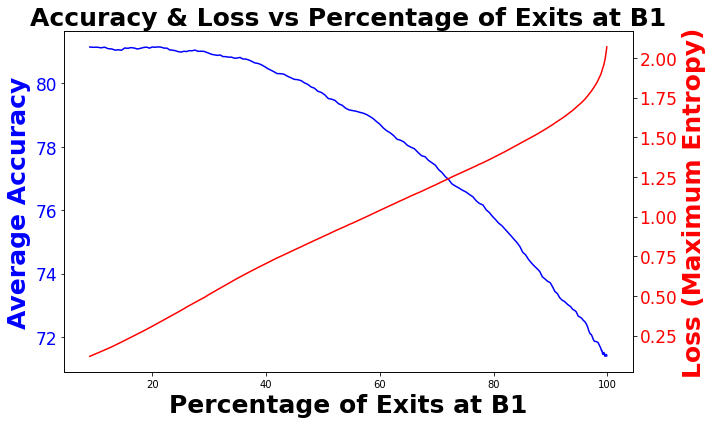

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Read CSV file
csv_file = file_path  # Replace with your CSV file path
data = pd.read_csv(csv_file)

# Calculate percentage of exits for x-axis
data['Percentage of Exits'] = data['B1 exit'] / 5000

# Calculate moving averages to smooth the line graph
def moving_average(values, window_size):
    return np.convolve(values, np.ones(window_size) / window_size, mode='valid')

# Define window size for moving average
window_size = 25

# Prepare data for plotting
x_values = data['Percentage of Exits'] * 100
accuracy_values = data['Average Accuracy'] * 100
entropy_values = data['Loss'] 

# Smooth the data using moving averages
smoothed_accuracy = moving_average(accuracy_values, window_size)
smoothed_entropy = moving_average(entropy_values, window_size)
smoothed_x = moving_average(x_values, window_size)

# Create a plot
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Accuracy on the left y-axis
ax1.set_xlabel('Percentage of Exits at B1',color='black', fontdict={'fontsize': 25, 'fontweight': 'bold'})
ax1.set_ylabel('Average Accuracy', color='b', fontdict={'fontsize': 25, 'fontweight': 'bold'})
ax1.plot(smoothed_x, smoothed_accuracy, color='b', label='Average Accuracy')
ax1.tick_params(axis='y', labelcolor='b', labelsize=17)

# Create a second y-axis for Loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss (Maximum Entropy)', color='r',fontdict={'fontsize': 25, 'fontweight': 'bold'})
ax2.plot(smoothed_x, smoothed_entropy, color='r', label='Loss (Maximum Entropy)')
ax2.tick_params(axis='y', labelcolor='r',labelsize=17)

# Add title and legend
plt.title('Accuracy & Loss vs Percentage of Exits at B1', fontdict={'fontsize': 25, 'fontweight': 'bold'})
fig.tight_layout()

# Display the plot
plt.show()


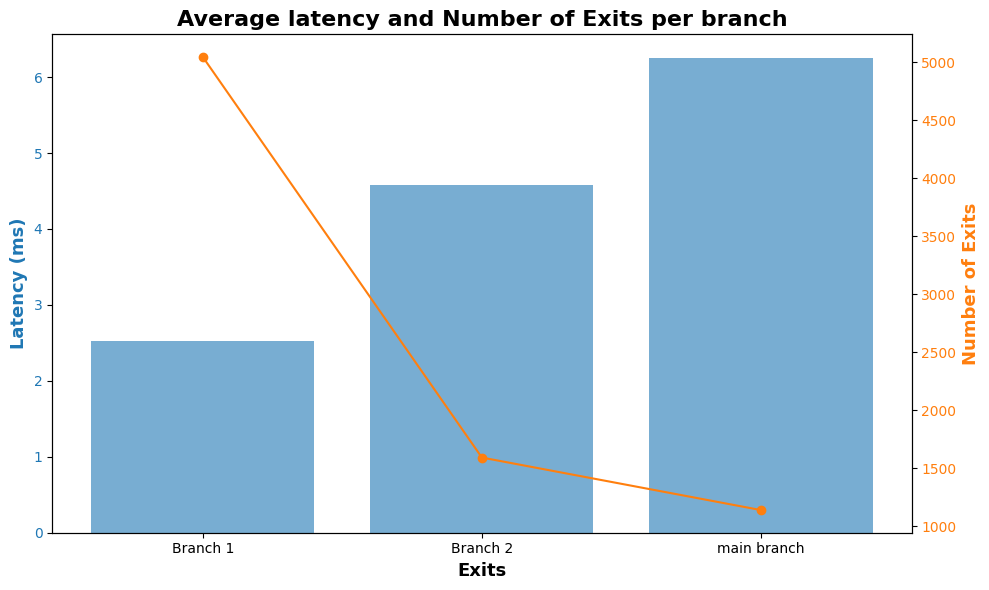

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame
data = {
    'Labels': ['Branch 1', 'Branch 2', 'main branch'],
    'Latency': [2.528, 4.582, 6.251],
    'Number of Exits': [5047, 1592, 1139]
}

df = pd.DataFrame(data)

# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the Latency data on the left Y-axis
ax1.set_xlabel('Exits', fontdict={'fontsize': 13, 'fontweight': 'bold', 'color': 'black'})
ax1.set_ylabel('Latency (ms)', color='tab:blue', fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax1.bar(df['Labels'], df['Latency'], color='tab:blue', label='Latency', alpha=0.6)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create another Y-axis for Number of Exits
ax2 = ax1.twinx()
ax2.set_ylabel('Number of Exits', color='tab:orange',fontdict={'fontsize': 13, 'fontweight': 'bold'})
ax2.plot(df['Labels'], df['Number of Exits'], color='tab:orange', marker='o', linestyle='-', label='Number of Exits')
ax2.tick_params(axis='y', labelcolor='tab:orange')

# Adding titles and labels
plt.title('Average latency and Number of Exits per branch',fontdict={'fontsize': 16, 'fontweight': 'bold'})
fig.tight_layout()  # Adjust layout to prevent overlap

# Display the plot
plt.show()


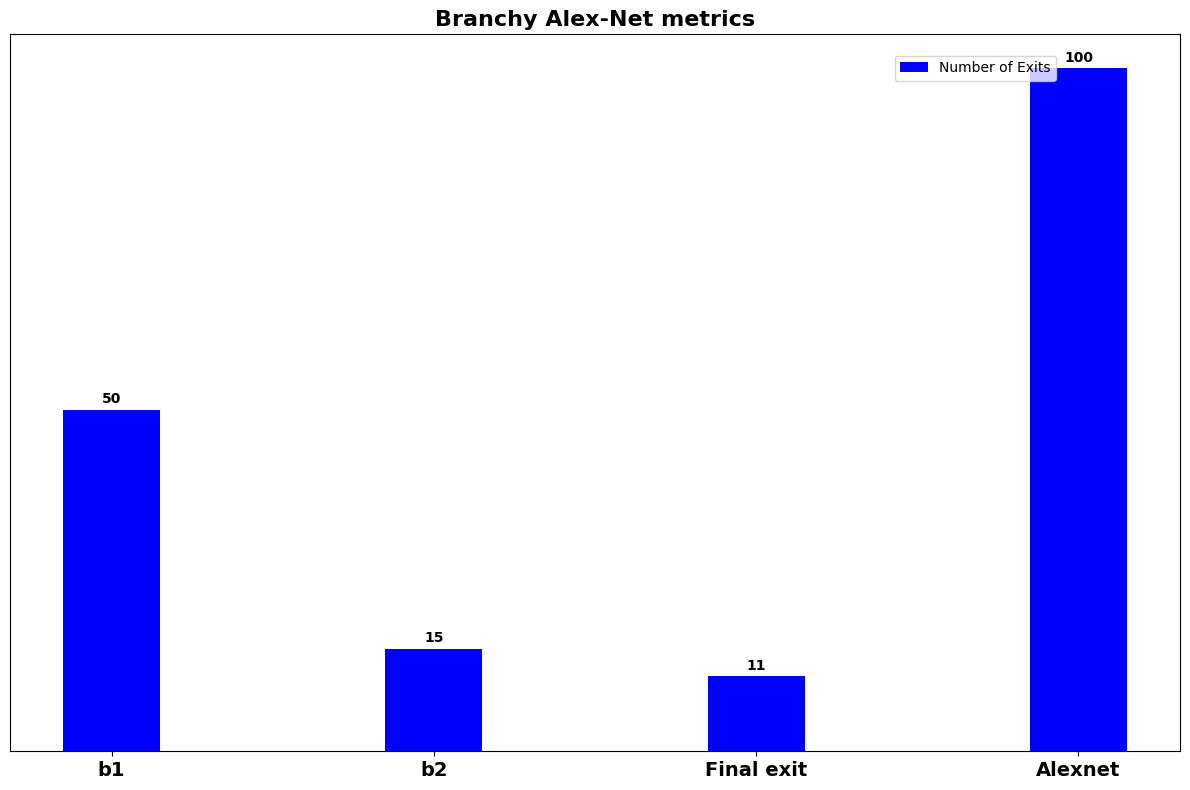

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits']#, 'Latency (100us)',  'Accuracy (%)', 'Data Ingress (Kb)','Flops (million)']
x_labels = ['b1', 'b2', 'Final exit', 'Alexnet']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 12, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 256, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70, 128, 163.0]     # Example values for b3
values_alexnet = [10000, 3.28, 70, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Create a new figure with specified size
fig, ax = plt.subplots(figsize=(12, 8))

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)


# Create an array for the bar positions
bar_width = 0.15  # Width of each bar
spacing_between_bars = 0.05  # Space between individual bars within a group
group_spacing = 0.3  # Spacing between groups

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Plot bars for each characteristic
for i in range(num_bars):
    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + i * (bar_width + spacing_between_bars)

    # Plot bars
    ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        label=categories[i],
        color=colors[i]
    )

    # Add text on top of each bar
    for j in range(num_groups):
        value = data[j][i]
        ax.text(
            positions[j],
            value + 0.5,  # Adjust the position slightly above the bar
            f'{value}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

# Labeling and formatting
ax.set_xticks(np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + (num_bars - 1) * (bar_width + spacing_between_bars) / 2)
ax.set_xticklabels(x_labels,fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_title('Branchy Alex-Net metrics',fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.legend(loc='upper right', bbox_to_anchor=(0.9, 0.98))

# Remove y-axis label
ax.yaxis.set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()
# plt.savefig("branchynet-metrics-no-exit.jpg")

# 

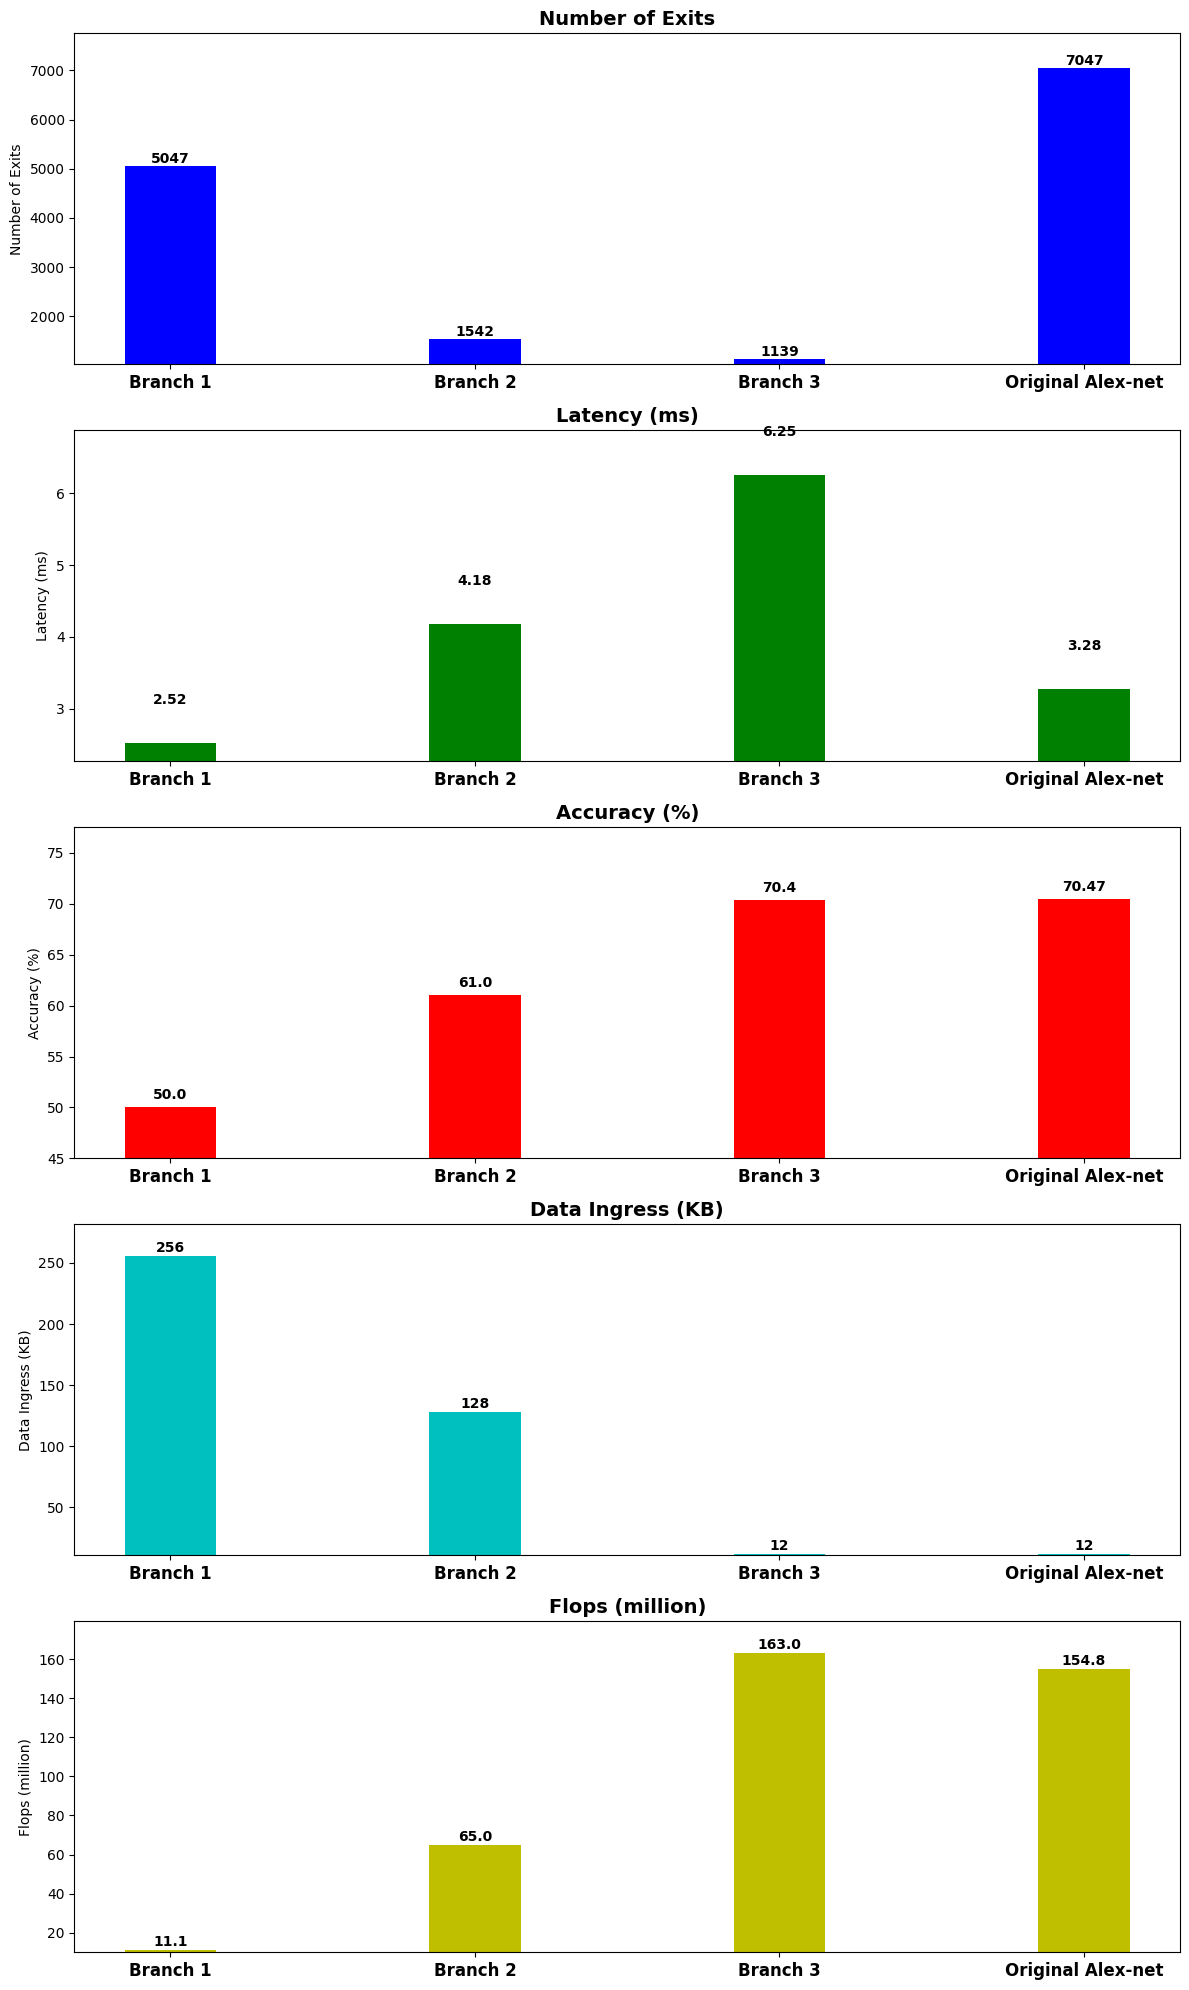

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Create a new figure with specified size
fig, axes = plt.subplots(nrows=num_bars, ncols=1, figsize=(12, 4*num_bars))

# Plot each metric in a separate subplot
bar_width = 0.3  # Reduce bar width
bar_spacing = 0  # Increase bar spacing

# Plot each metric in a separate subplot
for i, ax in enumerate(axes):
    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) 


    # Plot bars for each characteristic
    bars = ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        color=colors[i]
    )

    # Add text on top of each bar
    for j, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,  # Adjust the position slightly above the bar
            f'{bar.get_height()}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

    # Labeling and formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels, fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title(categories[i], fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_ylabel(categories[i])

    # Set y-axis range
    min_value = min([data[j][i] for j in range(num_groups)])
    max_value = max([data[j][i] for j in range(num_groups)])
    ax.set_ylim(min_value - (0.1 * min_value), max_value + (0.1 * max_value))  # Add 10% padding

plt.tight_layout()
plt.show()
# plt.savefig("branchynet-metrics-no-exit.jpg")


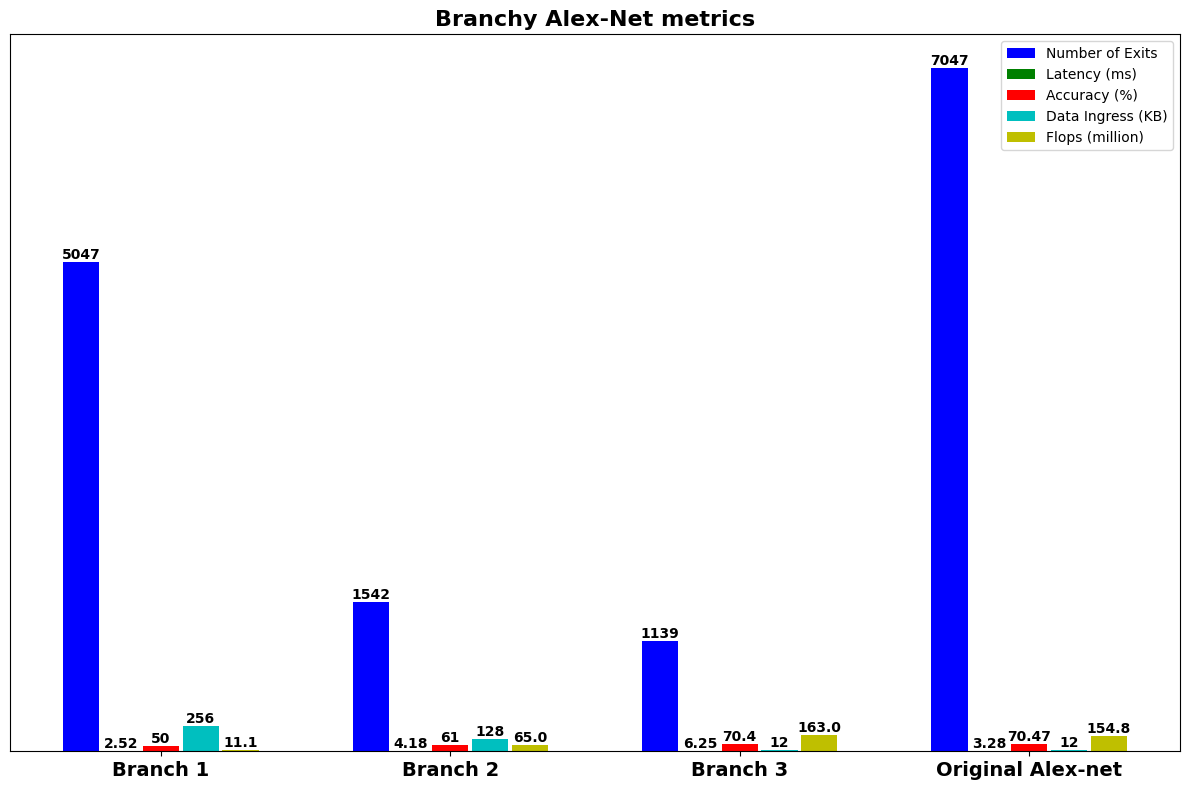

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]       # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Create a new figure with specified size
fig, ax = plt.subplots(figsize=(12, 8))

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Create an array for the bar positions
bar_width = 0.2  # Width of each bar
spacing_between_bars = 0.02  # Space between individual bars within a group
group_spacing = 0.5  # Spacing between groups

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Plot bars for each characteristic
for i in range(num_bars):
    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + i * (bar_width + spacing_between_bars)

    # Plot bars
    ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        label=categories[i],
        color=colors[i]
    )

    # Add text on top of each bar
    for j in range(num_groups):
        value = data[j][i]
        ax.text(
            positions[j],
            value + 0.5,  # Adjust the position slightly above the bar
            f'{value}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

# Labeling and formatting
ax.set_xticks(np.arange(num_groups) * (num_bars * (bar_width + spacing_between_bars) + group_spacing) + (num_bars - 1) * (bar_width + spacing_between_bars) / 2)
ax.set_xticklabels(x_labels, fontdict={'fontsize': 14, 'fontweight': 'bold'})
ax.set_title('Branchy Alex-Net metrics', fontdict={'fontsize': 16, 'fontweight': 'bold'})
ax.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Remove y-axis label
ax.yaxis.set_visible(False)

# Display the plot
plt.tight_layout()
plt.show()
# plt.savefig("branchynet-metrics-no-exit.jpg")


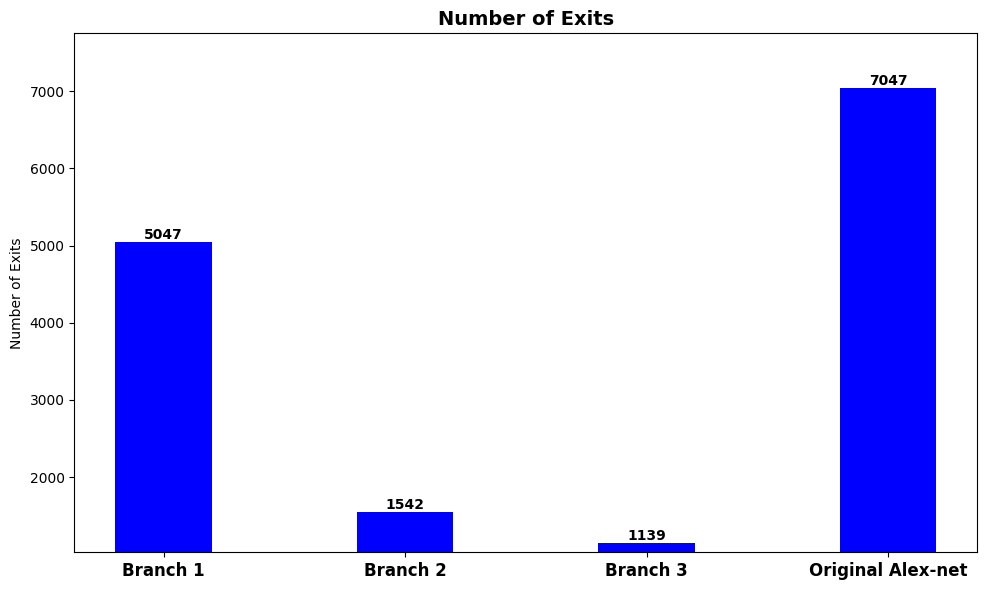

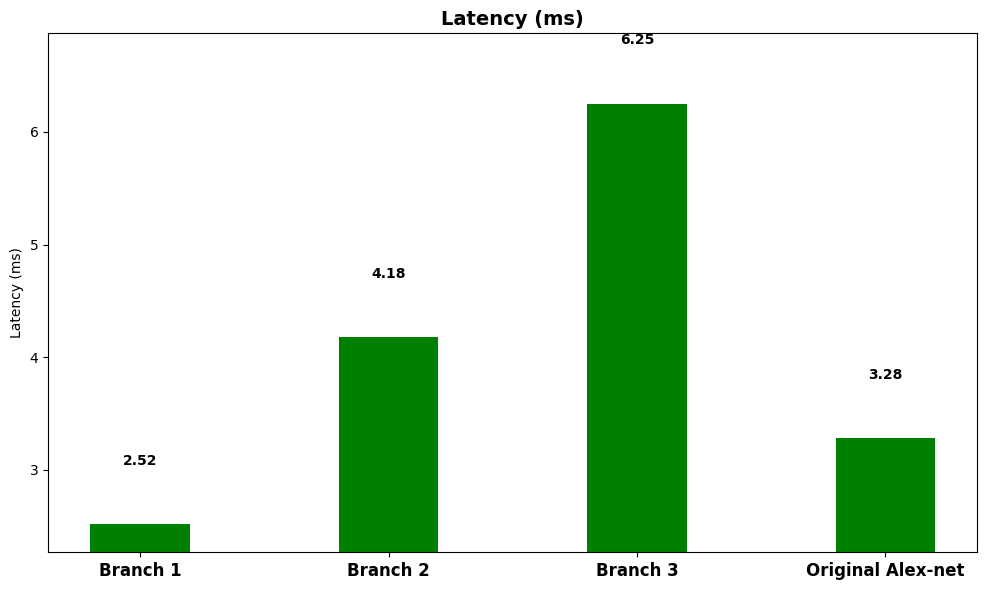

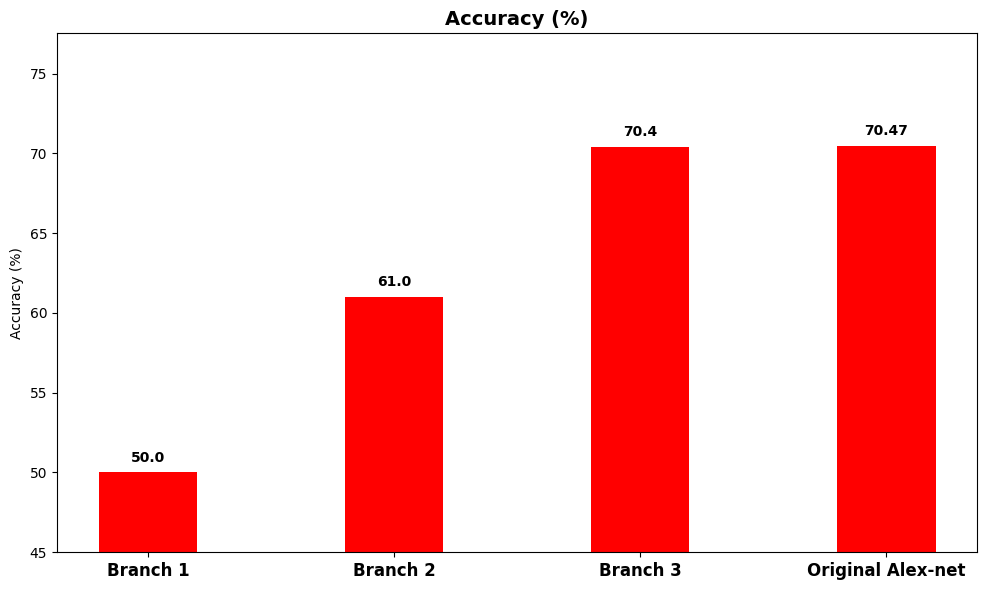

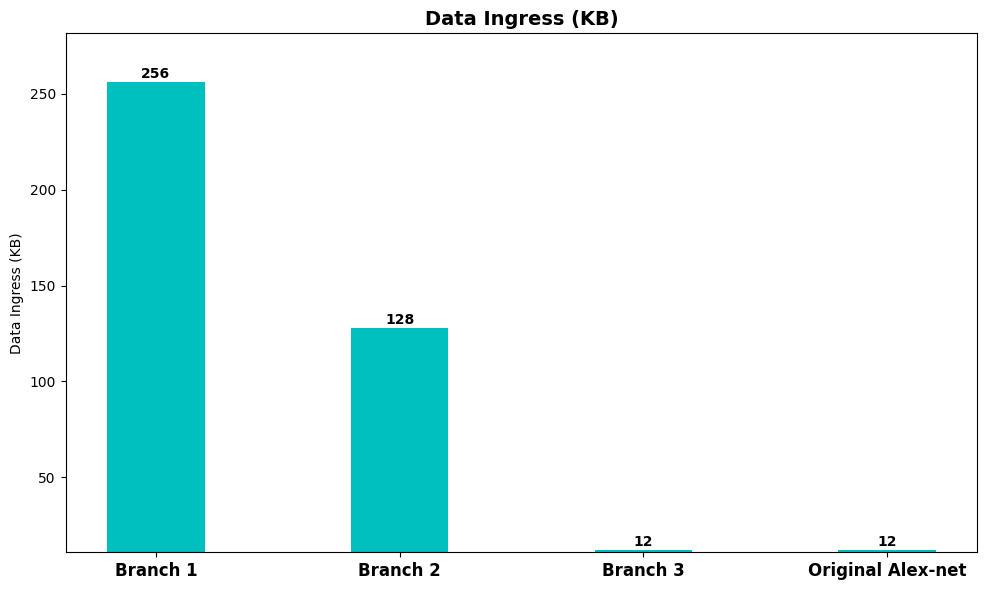

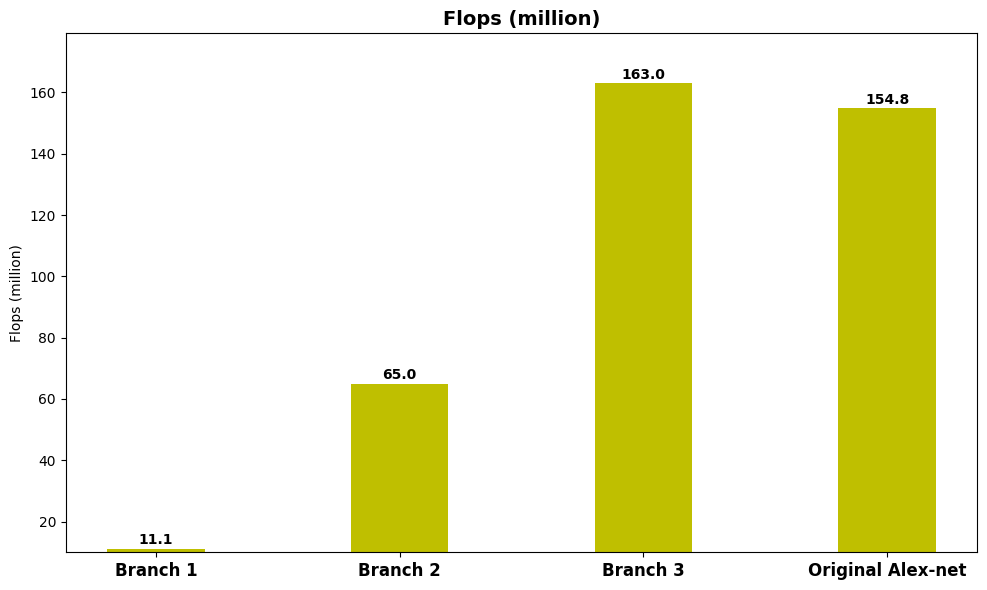

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Bar width
bar_width = 0.4

# Create a new figure for each metric
for i in range(num_bars):
    fig, ax = plt.subplots(figsize=(10, 6))

    # Position of bars on x-axis for this group
    positions = np.arange(num_groups)

    # Plot bars for each characteristic
    bars = ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        color=colors[i]
    )

    # Add text on top of each bar
    for j, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,  # Adjust the position slightly above the bar
            f'{bar.get_height()}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

    # Labeling and formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels, fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_title(categories[i], fontdict={'fontsize': 14, 'fontweight': 'bold'})
    ax.set_ylabel(categories[i])

    # Set y-axis range
    min_value = min([data[j][i] for j in range(num_groups)])
    max_value = max([data[j][i] for j in range(num_groups)])
    ax.set_ylim(min_value - (0.1 * min_value), max_value + (0.1 * max_value))  # Add 10% padding

    plt.tight_layout()
    plt.show()
    # plt.savefig(f"{categories[i].lower().replace(' ', '_')}-metrics.jpg")


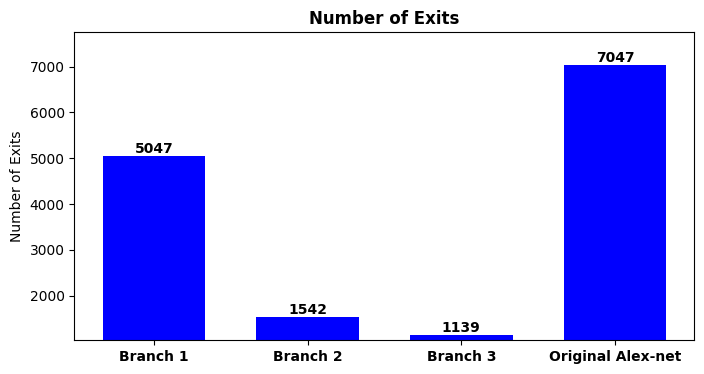

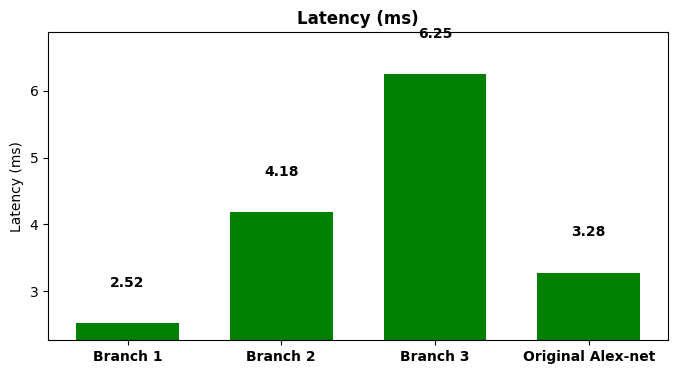

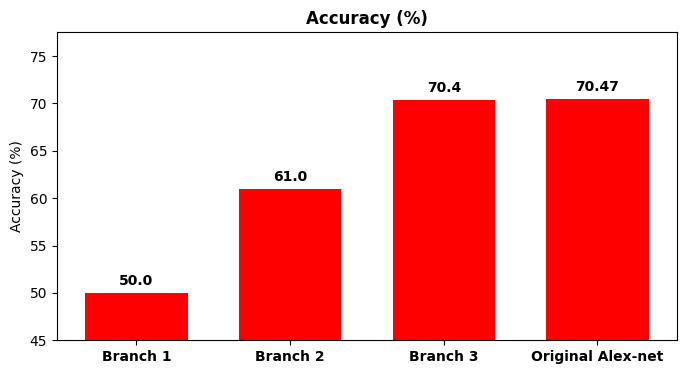

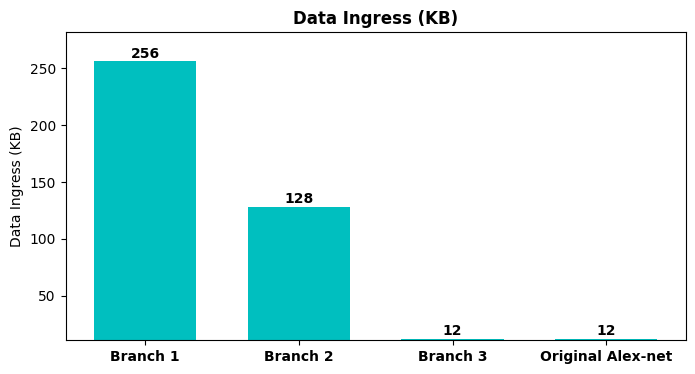

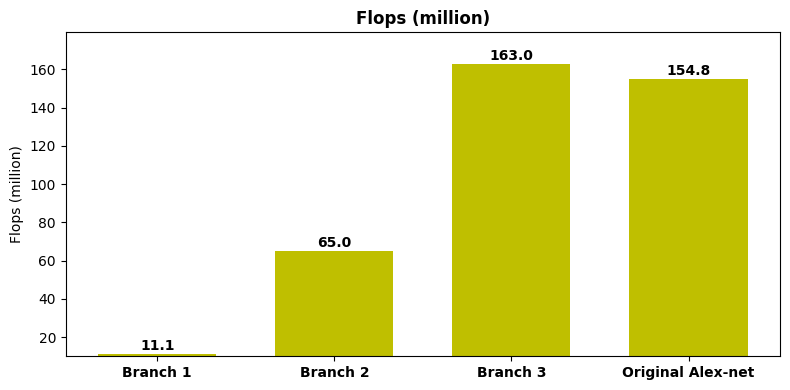

In [14]:
import matplotlib.pyplot as plt
import numpy as np

# Data
categories = ['Number of Exits', 'Latency (ms)', 'Accuracy (%)', 'Data Ingress (KB)', 'Flops (million)']
x_labels = ['Branch 1', 'Branch 2', 'Branch 3', 'Original Alex-net']

# Sample values for each characteristic per x-label
values_b1 = [5047, 2.52, 50, 256, 11.1]       # Example values for b1
values_b2 = [1542, 4.18, 61, 128, 65.0]      # Example values for b2
values_b3 = [1139, 6.25, 70.4, 12, 163.0]     # Example values for b3
values_alexnet = [7047, 3.28, 70.47, 12, 154.8] # Example values for Alexnet

# Combine the data into a list
data = [values_b1, values_b2, values_b3, values_alexnet]

# Number of groups and bars per group
num_groups = len(x_labels)
num_bars = len(categories)

# Colors for each characteristic
colors = ['b', 'g', 'r', 'c', 'y']

# Bar width
bar_width = 0.2

# Create a new figure for each metric
for i in range(num_bars):
    fig, ax = plt.subplots(figsize=(8, 4))  # Adjust the width of the figure

    # Position of bars on x-axis for this group
    positions = np.arange(num_groups) *0.3

    # Plot bars for each characteristic
    bars = ax.bar(
        positions,
        [data[j][i] for j in range(num_groups)],
        width=bar_width,
        color=colors[i]
    )

    # Add text on top of each bar
    for j, bar in enumerate(bars):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height() + 0.5,  # Adjust the position slightly above the bar
            f'{bar.get_height()}',
            ha='center',
            va='bottom',
            fontdict={'fontsize': 10, 'fontweight': 'bold'},
        )

    # Labeling and formatting
    ax.set_xticks(positions)
    ax.set_xticklabels(x_labels, fontdict={'fontsize': 10, 'fontweight': 'bold'})
    ax.set_title(categories[i], fontdict={'fontsize': 12, 'fontweight': 'bold'})
    ax.set_ylabel(categories[i])

    # Set y-axis range
    min_value = min([data[j][i] for j in range(num_groups)])
    max_value = max([data[j][i] for j in range(num_groups)])
    ax.set_ylim(min_value - (0.1 * min_value), max_value + (0.1 * max_value))  # Add 10% padding

plt.tight_layout()
plt.show()
    # plt.savefig(f"{categories[i].lower().replace(' ', '_')}-metrics.jpg")


In [ ]:
x